# Case Study: Student Performance Analysis

## Project Context 

An educational institution wanted to understand the key drivers of student performance in order to improve overall academic outcomes. The dataset contains student demographic information, study habits, and exam results.

As the Data Analyst, my role was to:
- Explore the data and identify performance patterns.
- Provide insights on factors influencing success.
- Recommend actionable strategies to support students at risk of failure.

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
plt.style.use('ggplot')

## 1. Data Info

In [3]:
df = pd.read_csv("C:/student_habits_performance.csv")
df

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,S1995,21,Female,2.6,0.5,1.6,No,77.0,7.5,Fair,2,High School,Good,6,Yes,76.1
996,S1996,17,Female,2.9,1.0,2.4,Yes,86.0,6.8,Poor,1,High School,Average,6,Yes,65.9
997,S1997,20,Male,3.0,2.6,1.3,No,61.9,6.5,Good,5,Bachelor,Good,9,Yes,64.4
998,S1998,24,Male,5.4,4.1,1.1,Yes,100.0,7.6,Fair,0,Bachelor,Average,1,No,69.7


In [4]:
#check for duplicates
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [5]:
#Count missing values per column
missing_per_col = df.isnull().sum()
print(missing_per_col)

student_id                        0
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64


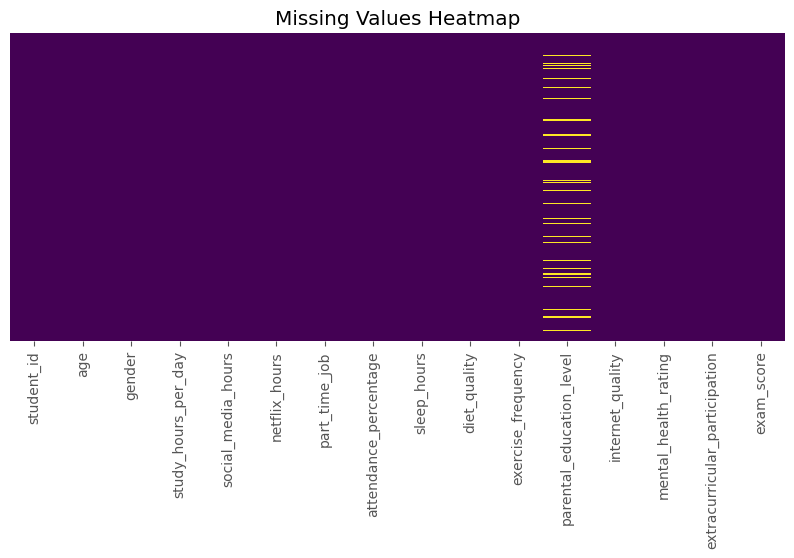

In [6]:
#Visualize missingness (using a heatmap)
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

## 2. Data Cleaning 

### 2.1 Fill null values in parental_education_level

#### KNN method 

We can also impute missing values in parental_education_level using a **KNN classifier** instead of a simple median/most‐frequent fill. The idea is:
- Separate the rows where parental_education_level is present (“train set” for the classifier) from those where it’s missing (“to‐impute” set).
- Encode all predictors (including gender, part_time_job, etc.) numerically.
- Train a KNN classifier on the non‐null rows to predict the (encoded) parental_education_level.
- Predict the missing rows and write those predictions back into the original DataFrame.

**Label‐encode our categorical target**
- KNN in scikit‐learn expects a numeric target → we use LabelEncoder to convert each unique category (e.g., “HighSchool”, “Bachelor”, “Master+”) into an integer.

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder #categorial predictors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# 1. Identify “target” and predictor columns
target_col = 'parental_education_level'
predictor_cols = [
    'age',
    'gender',
    'study_hours_per_day',
    'social_media_hours',
    'netflix_hours',
    'part_time_job',
    'attendance_percentage',
    'sleep_hours',
    'diet_quality',
    'exercise_frequency',
    'internet_quality',
    'mental_health_rating',
    'extracurricular_participation',
    'exam_score'
]

Rows where parental_education_level is NOT null → **used to train KNN** 

Rows where parental_education_level IS null → we’ll **predict** these

In [8]:
# 2. Split into “train” (non‐null) and “to‐impute” (null) sets
df_train = df[df[target_col].notna()].copy()
df_missing = df[df[target_col].isna()].copy()

# 3. Split predictor columns numeric vs. categorical
numeric_preds = df_train[predictor_cols].select_dtypes(include=['int64','float64']).columns.tolist()
categorical_preds = [c for c in predictor_cols if c not in numeric_preds]

In [9]:
# 4. Fill missing in df_train and df_missing

# 4.1 Extract median from numeric df_train cols
num_medians = df_train[numeric_preds].median()
#  Extract mode from categorical df_train cols
cat_modes = df_train[categorical_preds].mode().iloc[0]

# 4.2 Fill 
df_train[numeric_preds] = df_train[numeric_preds].fillna(num_medians)
df_train[categorical_preds] = df_train[categorical_preds].fillna(cat_modes)

df_missing[numeric_preds] = df_missing[numeric_preds].fillna(num_medians)
df_missing[categorical_preds] = df_missing[categorical_preds].fillna(cat_modes)
# 5. Encode the target labels
le = LabelEncoder()
y_train = le.fit_transform(df_train[target_col])

# 6. One‐hot encode predictors via pandas.get_dummies (drop_first=True)
X_train = pd.get_dummies(df_train[predictor_cols], drop_first=True)
X_missing = pd.get_dummies(df_missing[predictor_cols], drop_first=True)

The *get_dummies* function in pandas is used for one-hot encoding, converting categorical variables into numerical format. (In our case, we're converting the columns *diet_quality* & *internet_quality*)

In [10]:
# 7. Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)

# 8. Predict missing “parental_education_level” and write back
preds_encoded = knn.predict(X_missing)
df.loc[df[target_col].isna(), target_col] = le.inverse_transform(preds_encoded)

In [11]:
#Count missing values per column after KNN classifier
missing_per_col = df.isna().sum()
print(missing_per_col)

student_id                       0
age                              0
gender                           0
study_hours_per_day              0
social_media_hours               0
netflix_hours                    0
part_time_job                    0
attendance_percentage            0
sleep_hours                      0
diet_quality                     0
exercise_frequency               0
parental_education_level         0
internet_quality                 0
mental_health_rating             0
extracurricular_participation    0
exam_score                       0
dtype: int64


### 2.2 Feature Engineering 

In [12]:
# check unique values in each categorical column
cat_cols = ["gender", "part_time_job", "parental_education_level",
            "internet_quality", "diet_quality", "extracurricular_participation"]
for col in cat_cols :
    print(f"{col} : {df[col].unique()}")

gender : ['Female' 'Male' 'Other']
part_time_job : ['No' 'Yes']
parental_education_level : ['Master' 'High School' 'Bachelor']
internet_quality : ['Average' 'Poor' 'Good']
diet_quality : ['Fair' 'Good' 'Poor']
extracurricular_participation : ['Yes' 'No']


In [13]:
#add a total_screen_time column
df["total_screen_time"]= df["social_media_hours"]+ df["netflix_hours"]
df["total_screen_time"]

0      2.3
1      5.1
2      4.4
3      4.9
4      4.9
      ... 
995    2.1
996    3.4
997    3.9
998    5.2
999    4.8
Name: total_screen_time, Length: 1000, dtype: float64

### Outliers Detection and values standardization

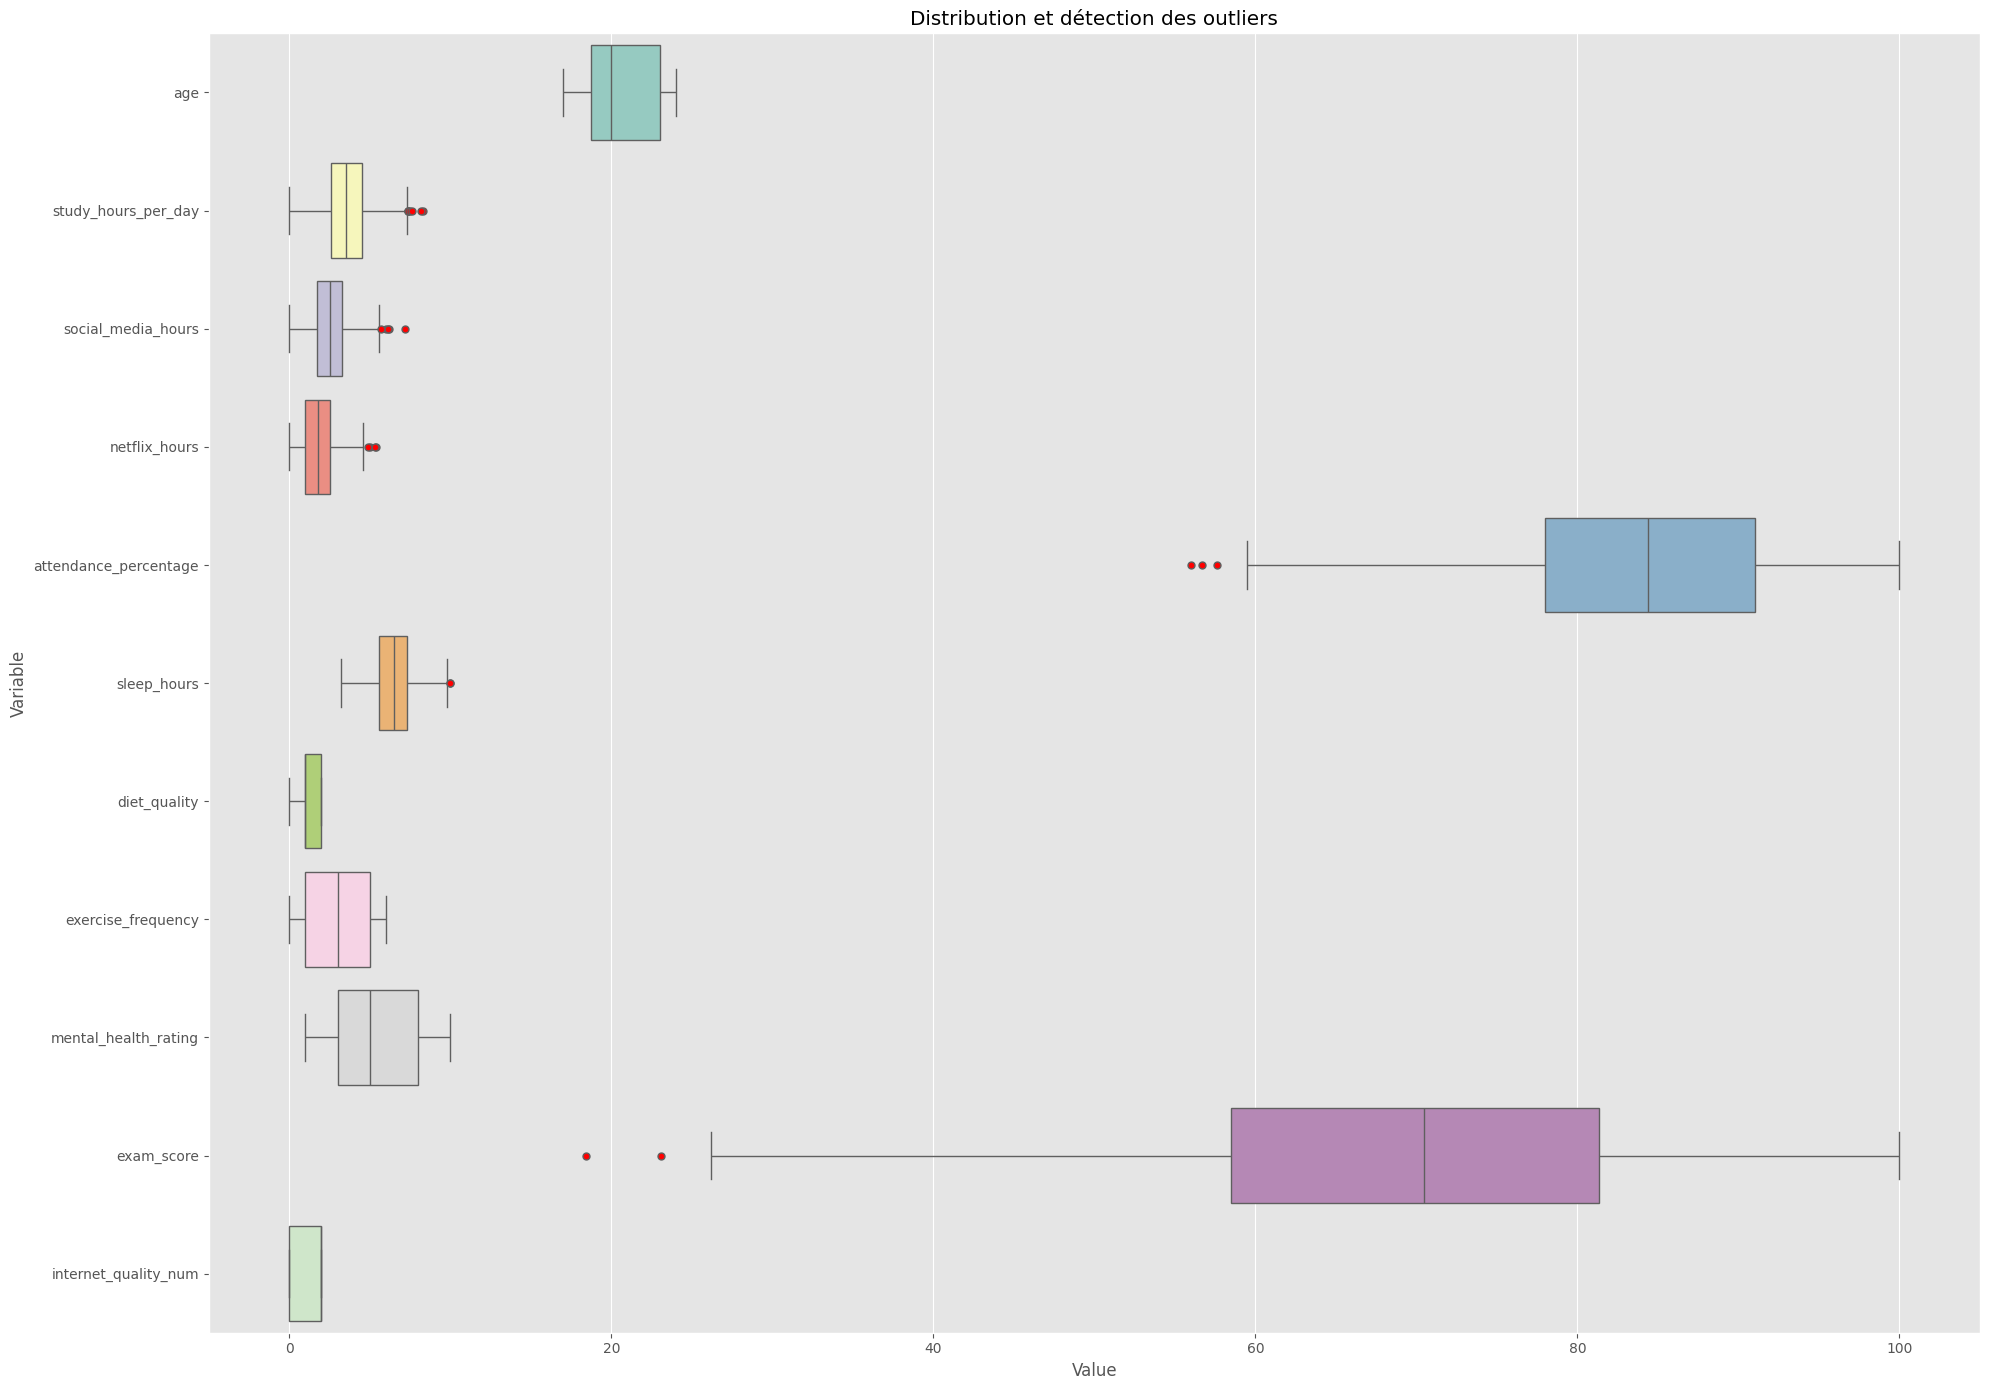

In [14]:
# Define a mapping for internet_quality
df['internet_quality_num'] = df['internet_quality'].map({
    "Poor": 0,
    "Fair": 1,
    "Good": 2
})
# Define a mapping for diet_quality
df['diet_quality'] = df['diet_quality'].map({
    "Poor": 0,
    "Fair": 1,
    "Good": 2
})

# Now include it alongside other numeric columns
numerical_cols = [
    'age',
    'study_hours_per_day',
    'social_media_hours',
    'netflix_hours',
    'attendance_percentage',
    'sleep_hours',
    'diet_quality',
    'exercise_frequency',
    'mental_health_rating',
    'exam_score',
    'internet_quality_num'
]

df_melted = df[numerical_cols].melt(var_name='Variable', value_name='Value')

plt.figure(figsize=(20, 14))
sns.boxplot(
    x='Value',
    y='Variable',
    data=df_melted,
    showfliers=True,
    flierprops={'markerfacecolor': 'red', 'marker': 'o', 'markersize': 5}, 
    palette="Set3"
)
plt.title("Distribution et détection des outliers")
plt.tight_layout()
plt.show()

#### Detecting numeric outliers (IQR method)

In [15]:
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)]

In [16]:
# Outliers in “study_hours_per_day”
outliers_study = detect_outliers_iqr(df["study_hours_per_day"])
print("Outliers in study_hours_per_day:\n", outliers_study)

Outliers in study_hours_per_day:
 73     7.4
293    7.4
455    8.3
489    7.4
774    7.5
797    8.2
875    7.6
Name: study_hours_per_day, dtype: float64


In [17]:
# Outliers in “netflix_hours"
outliers_study = detect_outliers_iqr(df["netflix_hours"])
print("Outliers in netflix_hours:\n", outliers_study)

Outliers in netflix_hours:
 81     5.0
556    5.4
822    5.3
887    4.9
Name: netflix_hours, dtype: float64


In [18]:
# Outliers in “social_media_hours"
outliers_study = detect_outliers_iqr(df["social_media_hours"])
print("Outliers in social_media_hours:\n", outliers_study)

Outliers in social_media_hours:
 145    6.2
346    6.0
361    6.1
641    5.7
735    7.2
Name: social_media_hours, dtype: float64


In [19]:
# Outliers in “attendance_percentage"
outliers_study = detect_outliers_iqr(df["attendance_percentage"])
print("Outliers in attendance_percentage:\n", outliers_study)

Outliers in attendance_percentage:
 651    57.6
706    56.7
971    56.0
Name: attendance_percentage, dtype: float64


In [20]:
# Outliers in “exam_score"
outliers_study = detect_outliers_iqr(df["exam_score"])
print("Outliers in exam_score:\n", outliers_study)

Outliers in exam_score:
 265    18.4
327    23.1
Name: exam_score, dtype: float64


#### Standardize the values

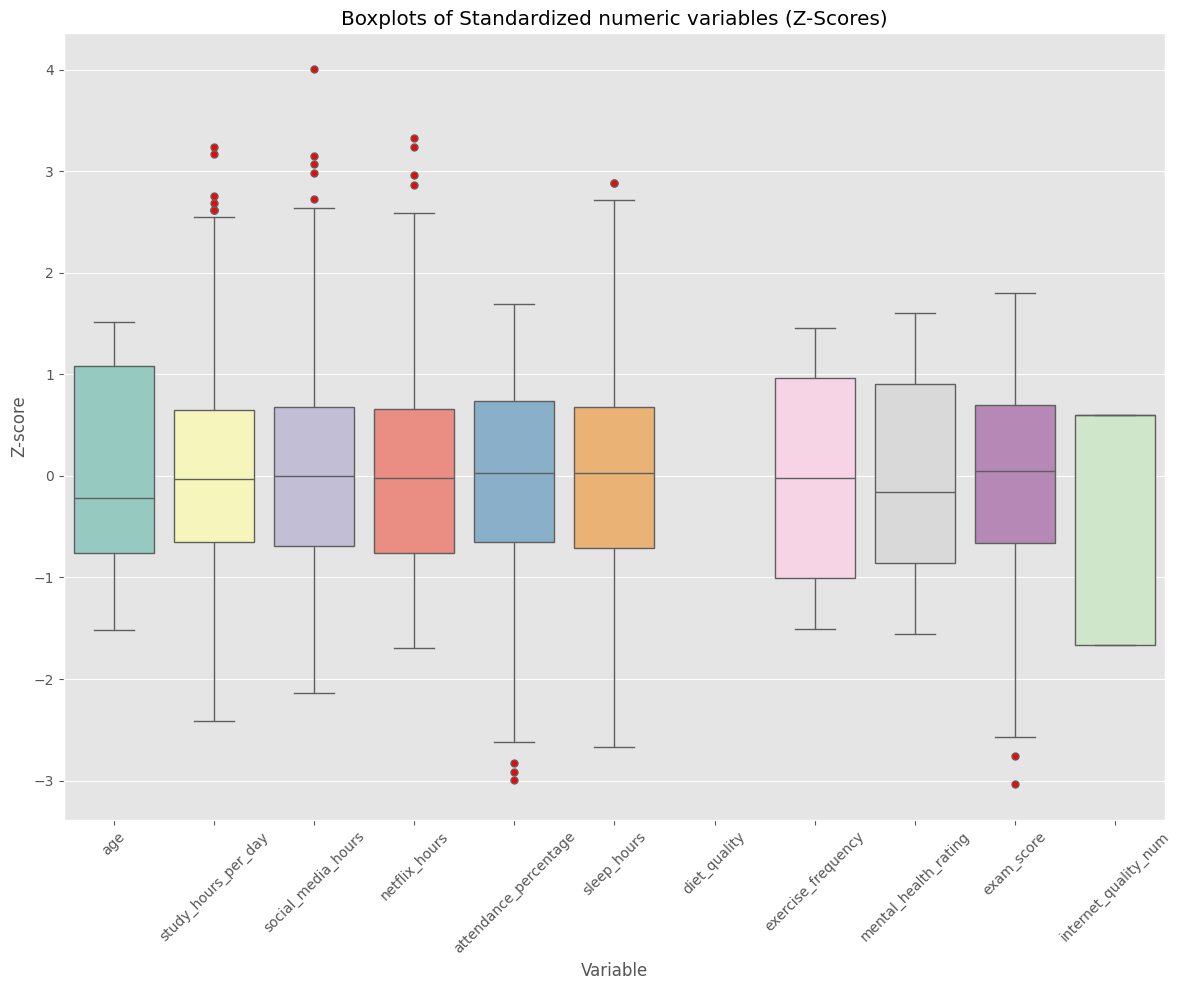

In [21]:
from sklearn.preprocessing import StandardScaler

df['internet_quality_num'] = df['internet_quality'].map({
    "Poor": 0,
    "Fair": 1,
    "Good": 2
})
df['diet_quality'] = df['diet_quality'].map({
    "Poor": 0,
    "Fair": 1,
    "Good": 2
})

numerical_cols = [
    'age',
    'study_hours_per_day',
    'social_media_hours',
    'netflix_hours',
    'attendance_percentage',
    'sleep_hours',
    'diet_quality',
    'exercise_frequency',
    'mental_health_rating',
    'exam_score',
    'internet_quality_num'
]

#Standardize
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df[numerical_cols])
df_scaled = pd.DataFrame(scaled_array, columns=numerical_cols)

# Melt & plot
df_melted_scaled = df_scaled.melt(var_name='Variable', value_name='Z_score')

plt.figure(figsize=(12, 10))
sns.boxplot(
    x='Variable',
    y='Z_score',
    data=df_melted_scaled,
    showfliers=True,
    flierprops={'markerfacecolor': 'red', 'marker': 'o', 'markersize': 5}, 
    palette="Set3"
)
plt.title("Boxplots of Standardized numeric variables (Z-Scores)")
plt.ylabel("Z-score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Exploratory Data Analysis + Insights

### Correlation

Top correlations with exam_score:


study_hours_per_day      0.825419
mental_health_rating     0.321523
total_screen_time       -0.237631
netflix_hours           -0.171779
social_media_hours      -0.166733
exercise_frequency       0.160107
sleep_hours              0.121683
attendance_percentage    0.089836
internet_quality_num    -0.029372
age                     -0.008907
Name: exam_score, dtype: float64

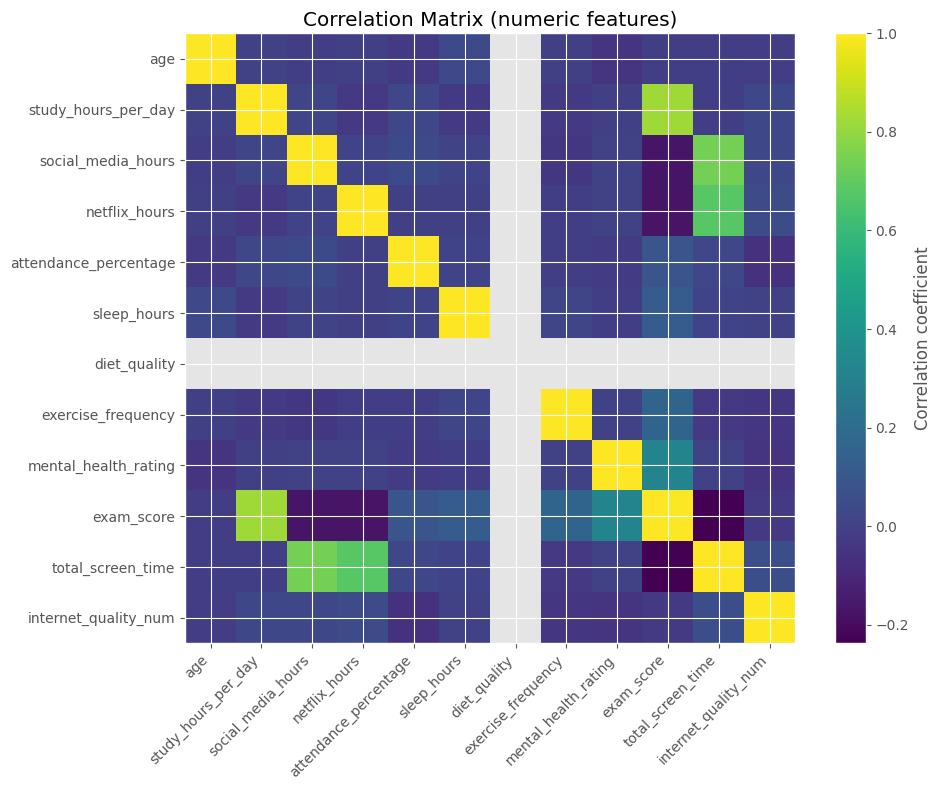

In [22]:
#Correlation matrix (numeric features only)
# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if "exam_score" not in numeric_cols:
    raise ValueError("The target column 'exam_score' must be numeric for correlation calc.")

# Compute correlations
corr = df[numeric_cols].corr()

# print strongest correlations with exam_score
corr_with_target = corr["exam_score"].drop("exam_score").sort_values(key=lambda x: x.abs(), ascending=False)
print("Top correlations with exam_score:")
display(corr_with_target.head(10))

# Plot correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(corr, interpolation="nearest")
plt.colorbar(label="Correlation coefficient")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Matrix (numeric features)")
plt.tight_layout()
plt.show()

Let's focus more on the most influencial columns on the exam score : 
1. study_hours_per_day
2. mental_health_rating

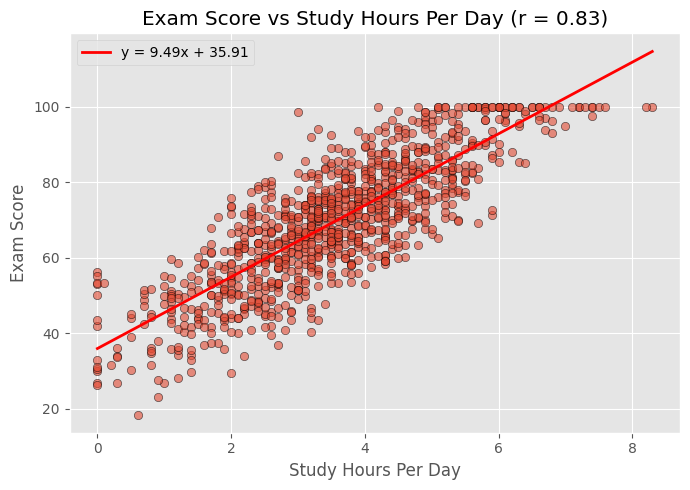

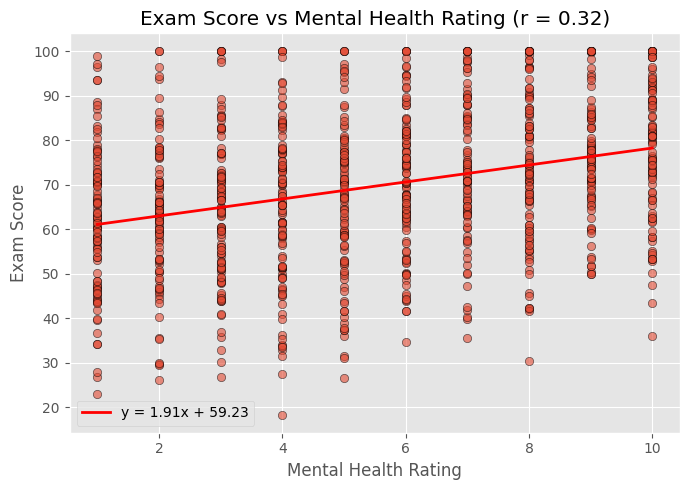

In [23]:
cols_to_plot = ["study_hours_per_day", "mental_health_rating"]

for col in cols_to_plot:
    tmp = df[[col, "exam_score"]].dropna()

    # Scatter plot
    plt.figure(figsize=(7,5))
    plt.scatter(tmp[col], tmp["exam_score"], alpha=0.6, edgecolor="k")

    # Add regression line
    m, b = np.polyfit(tmp[col], tmp["exam_score"], 1)
    x_vals = np.linspace(tmp[col].min(), tmp[col].max(), 100)
    plt.plot(x_vals, m*x_vals + b, color="red", linewidth=2, label=f"y = {m:.2f}x + {b:.2f}")

    # Labels and title
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel("Exam Score")
    corr_val = tmp[col].corr(tmp["exam_score"])
    plt.title(f"Exam Score vs {col.replace('_',' ').title()} (r = {corr_val:.2f})")
    plt.legend()
    plt.tight_layout()

### Random Forest Regressor (with preprocessing), metrics, and feature importances

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Target and feature columns
TARGET = "exam_score"
X_raw = df.drop(columns=[TARGET])
y = df[TARGET]

# Identify categorical vs numeric features
cat_cols = X_raw.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical features:", cat_cols)
print("Numeric features:", num_cols)

# Preprocessing:
# - Numeric: median imputation
# - Categorical: most_frequent imputation + one-hot encoding
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop",
)

# Model
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Pipeline = preprocessing + model
model = Pipeline(steps=[
    ("prep", preprocess),
    ("rf", rf),
])

# Split & fit
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

# Predict & metrics
y_pred = model.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = r2_score(y_test, y_pred)

print("Random Forest Regressor — Test Performance")
print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R^2 : {r2:.3f}")

Categorical features: ['student_id', 'gender', 'part_time_job', 'parental_education_level', 'internet_quality', 'extracurricular_participation']
Numeric features: ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'attendance_percentage', 'sleep_hours', 'diet_quality', 'exercise_frequency', 'mental_health_rating', 'total_screen_time', 'internet_quality_num']
Random Forest Regressor — Test Performance
MAE : 4.982
RMSE: 6.185
R^2 : 0.851


**Metrics recap & Interpretation**

* **MAE (Mean Absolute Error) = 5.0** → On average, the model’s predictions are about 5 points away from the true exam score. Acceptable but not perfect.
For instance, a student expected to score 75 might actually score anywhere from ~70 to ~80. 

* **RMSE (Root Mean Squared Error) = 6.3** → The overall the errors are still reasonable.

* **R² (Coefficient of Determination) = 0.845** → The model does a strong job of predicting exam scores: explaining **~85% of the outcome variation**. Meaning most variation in scores can be predicted from the input features.


→ The difference between MAE and RMSE suggests there are some larger outliers (students whose scores are harder to predict, maybe because of hidden factors like motivation or stress).

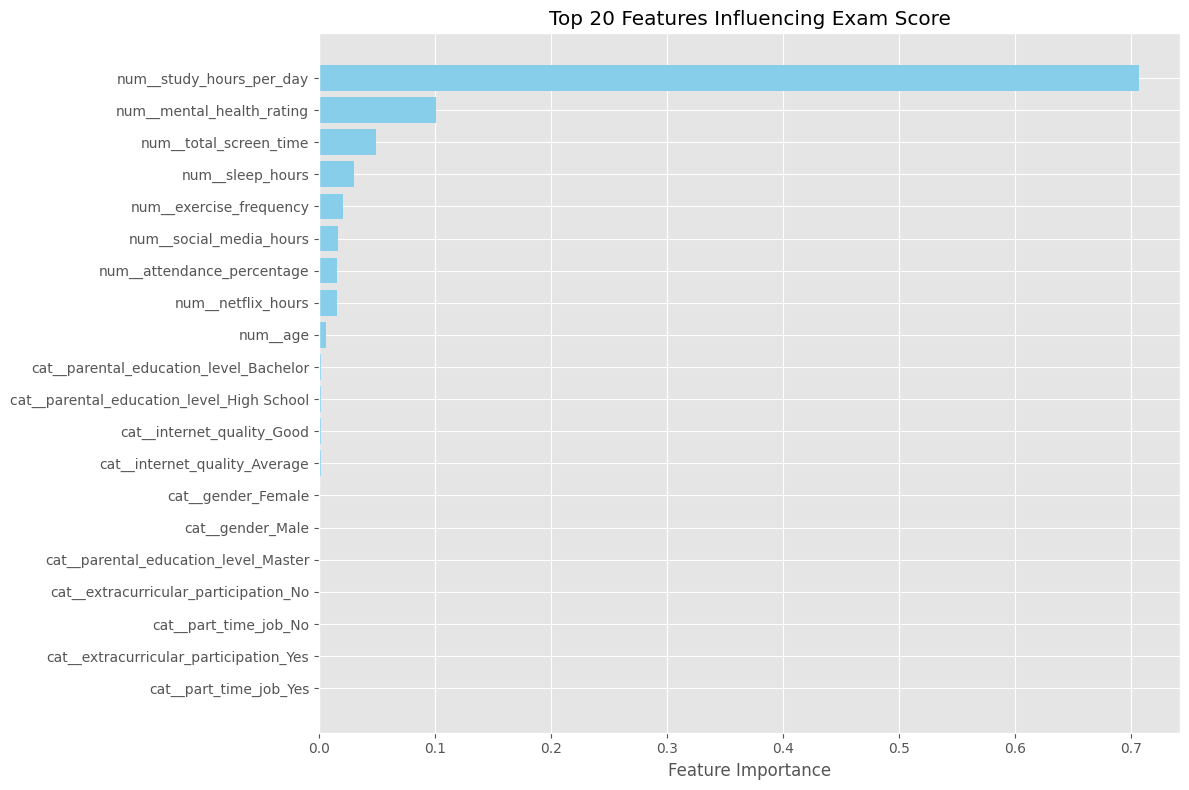

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Get feature importances from the trained RandomForest
importances = model.named_steps["rf"].feature_importances_

# 2. Get transformed feature names from the ColumnTransformer
all_features = model.named_steps["prep"].get_feature_names_out()

# 3. Create a DataFrame mapping feature names to importance
feat_imp = pd.DataFrame({
    "feature": all_features,
    "importance": importances
})

# 4. Sort features by importance
feat_imp = feat_imp.sort_values(by="importance", ascending=False).reset_index(drop=True)

# 5. Plot top 20 features
plt.figure(figsize=(12,8))
plt.barh(feat_imp["feature"][:20][::-1], feat_imp["importance"][:20][::-1], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Top 20 Features Influencing Exam Score")
plt.tight_layout()
plt.show()

### 3.1 Univariate Analysis 

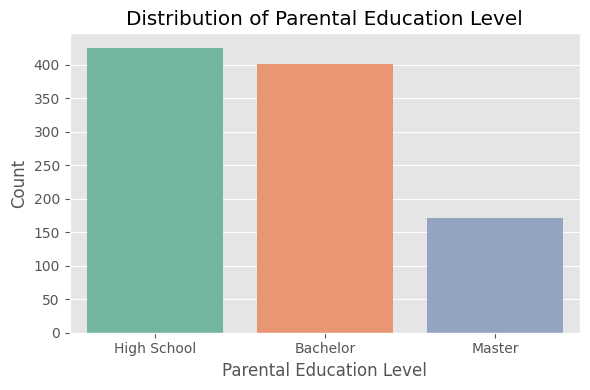

In [26]:
plt.figure(figsize=(6, 4))
sns.countplot(x="parental_education_level", data=df, order=df["parental_education_level"].value_counts().index, palette="Set2")
plt.title("Distribution of Parental Education Level")
plt.xlabel("Parental Education Level")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Age is between: 17 and 24


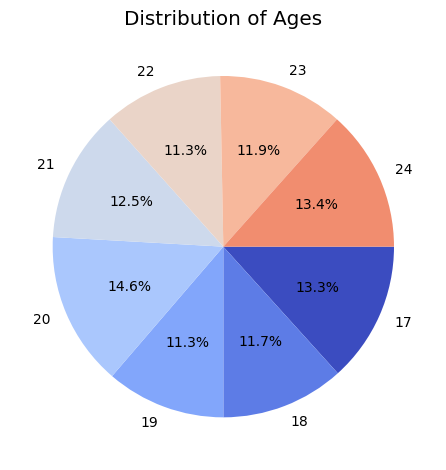

In [27]:
#print out the interval of ages
print(f"Age is between: {df['age'].min()} and {df['age'].max()}")

#pie plot
cmap = plt.cm.coolwarm 
colors = cmap(np.linspace(0, 1, 10))
age_var = df["age"].value_counts().sort_index()
plt.pie(
    age_var,
    labels=age_var.index,
    autopct="%1.1f%%", 
    colors=colors, 
    counterclock=False 
)
plt.title("Distribution of Ages")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'la distribution des ages des personnes interrogées')

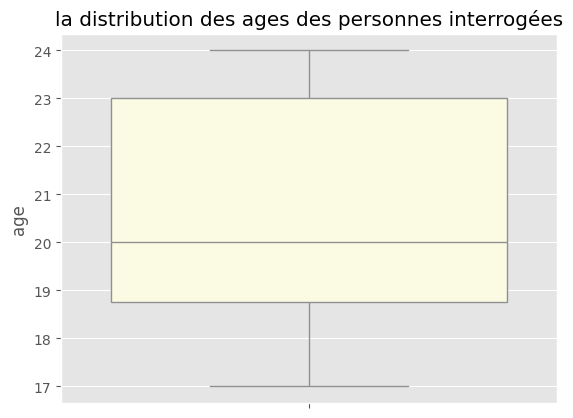

In [28]:
sns.boxplot(y=df['age'], color="lightyellow").set_title('la distribution des ages des personnes interrogées')

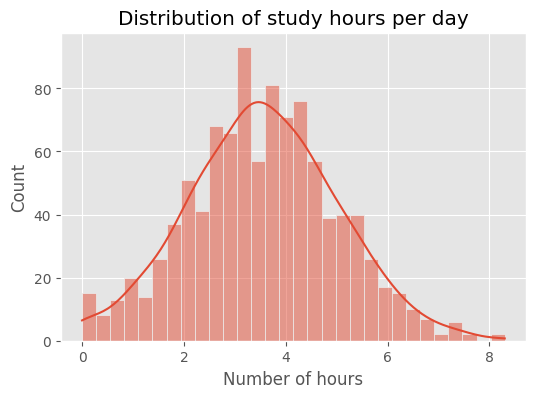

In [29]:
plt.figure(figsize=(6, 4))
sns.histplot(df["study_hours_per_day"], kde=True, bins=30)
plt.title("Distribution of study hours per day")
plt.xlabel("Number of hours")
plt.ylabel("Count")
plt.show()

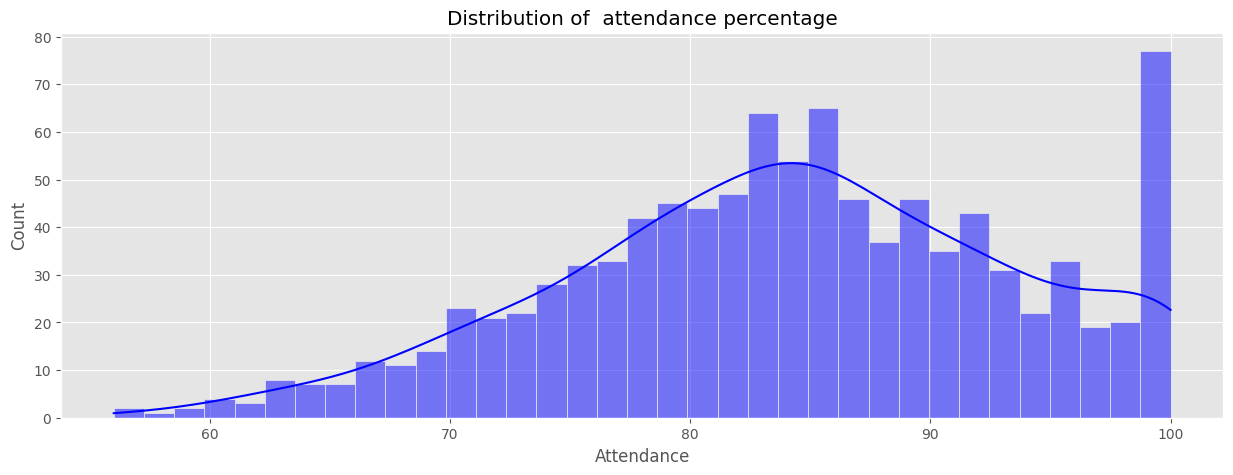

In [30]:
plt.figure(figsize=(15, 5))
sns.histplot(df[ "attendance_percentage"], kde=True, bins=35, color="blue")
plt.title("Distribution of  attendance percentage")
plt.xlabel("Attendance")
plt.ylabel("Count")
plt.show()

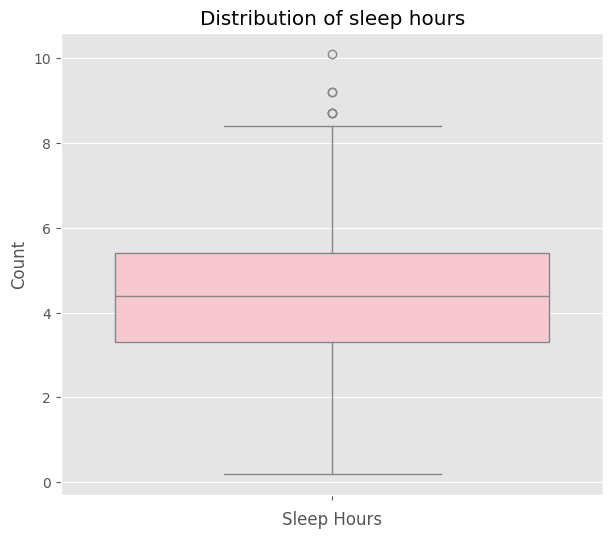

In [31]:
plt.figure(figsize=(7, 6))
sns.boxplot(df["total_screen_time"], color='pink')
plt.title("Distribution of sleep hours")
plt.xlabel("Sleep Hours")
plt.ylabel("Count")
plt.show()

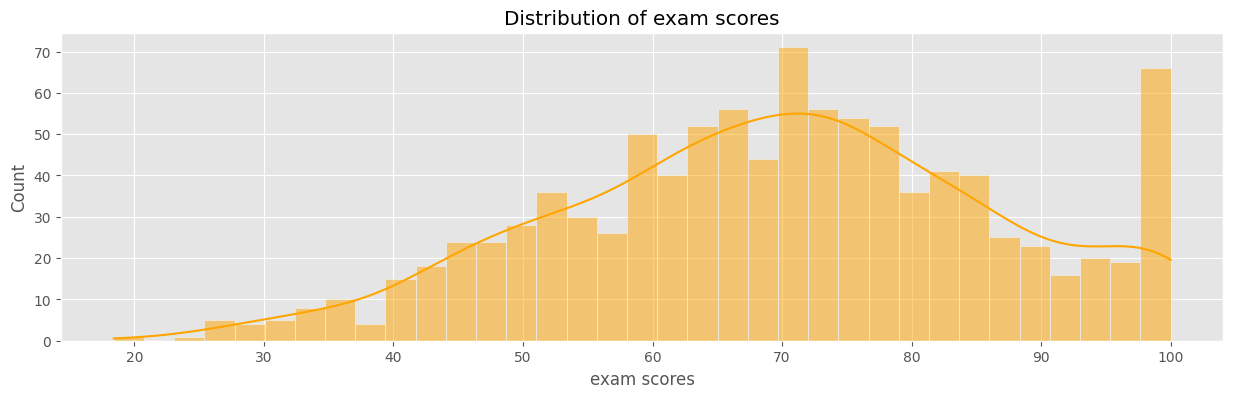

In [32]:
plt.figure(figsize=(15, 4))
sns.histplot(df["exam_score"], kde=True, bins=35, color="orange")
plt.title("Distribution of exam scores")
plt.xlabel("exam scores")
plt.ylabel("Count")
plt.show()

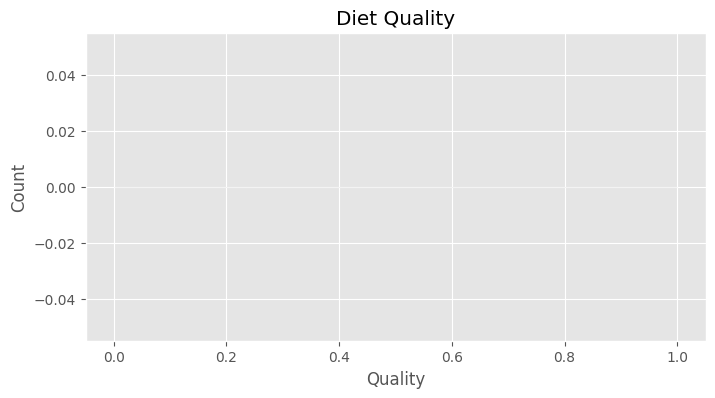

In [33]:
plt.figure(figsize=(8, 4))
cmap = plt.cm.magma
sns.histplot(df["diet_quality"], color=cmap(0.5))
plt.title("Diet Quality")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

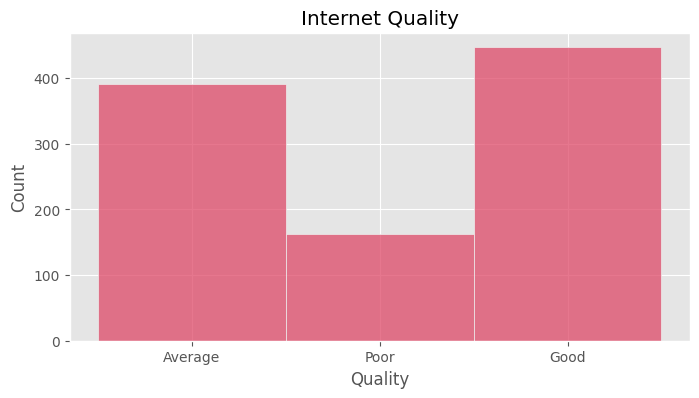

In [34]:
plt.figure(figsize=(8, 4))
cmap = plt.cm.magma
sns.histplot(df["internet_quality"], color=cmap(0.6))
plt.title("Internet Quality")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

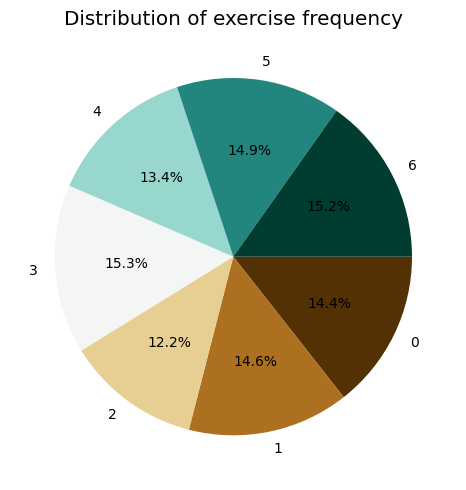

In [35]:
#1. Count how many times each exercise_frequency appears
exercise_count = df["exercise_frequency"].value_counts().sort_index()

#2. Generate  palette colors
cmap = plt.cm.BrBG 
colors = cmap(np.linspace(0, 1, len(exercise_count)))

#3. Pie chart
plt.figure(figsize=(10, 5))
plt.pie(
    exercise_count,
    labels=exercise_count.index,
    autopct="%1.1f%%",
    colors=colors, 
    counterclock=False 
)
plt.title("Distribution of exercise frequency")
plt.tight_layout()
plt.show()

### 3.2 Bivariate Analysis 

### Numeric–Numeric Relationships

#### Corelation between exam scores & total screen time

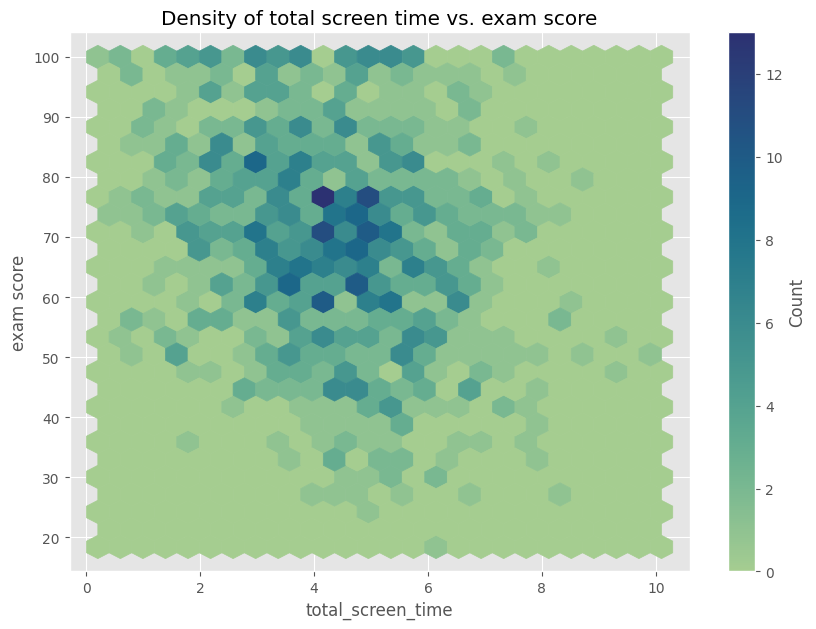

In [36]:
# Hexbin Plot to show point density
plt.figure(figsize=(10, 7))
plt.hexbin(df["total_screen_time"], df["exam_score"], gridsize=25, cmap="crest")
plt.colorbar(label='Count')
plt.xlabel("total_screen_time")
plt.ylabel("exam score")
plt.title("Density of total screen time vs. exam score")
plt.show()

- The darkest hexagons (highest counts) cluster around 4–6 hours of total screen time and exam scores of roughly 60–80, peaking near 4h / 75 points.
- Very low screen time (<2 h) and very high screen time (>8 h) are far less common and show a wider spread of scores. They're often below 60.

- **There’s no strong monotonic trend**. increasing screen time up to the mid-range correlates with better scores, but beyond ~6 h gains plateau or even reverse.

- Notably, perfect scores of 100 also occur for students with 3–6 h of screen time, indicating that this mid-range is where top performers concentrate.

#### Correlation between exam scores & sleep hours

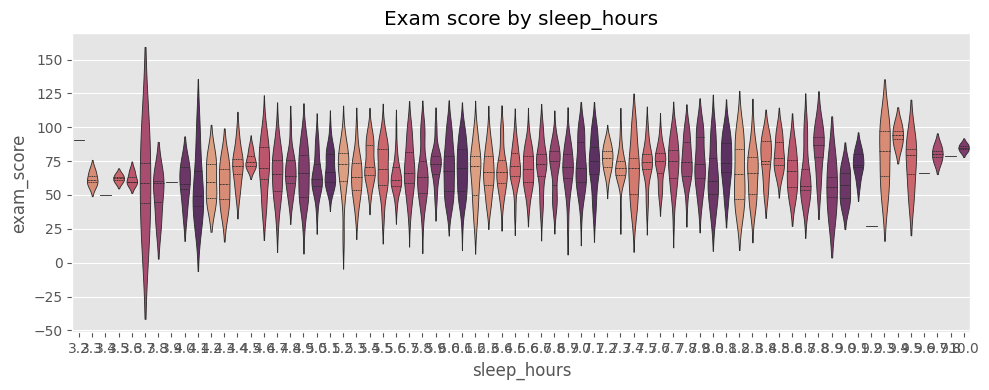

In [38]:
plt.figure(figsize=(10, 4))
sns.violinplot(
    x="sleep_hours",
    y="exam_score",
    data=df,
    inner="quartile", 
    palette=sns.color_palette("flare", 10))
plt.title("Exam score by sleep_hours")
plt.xlabel("sleep_hours")
plt.ylabel("exam_score")
plt.tight_layout()
plt.show()

#### Corelation between exam scores & social media hours

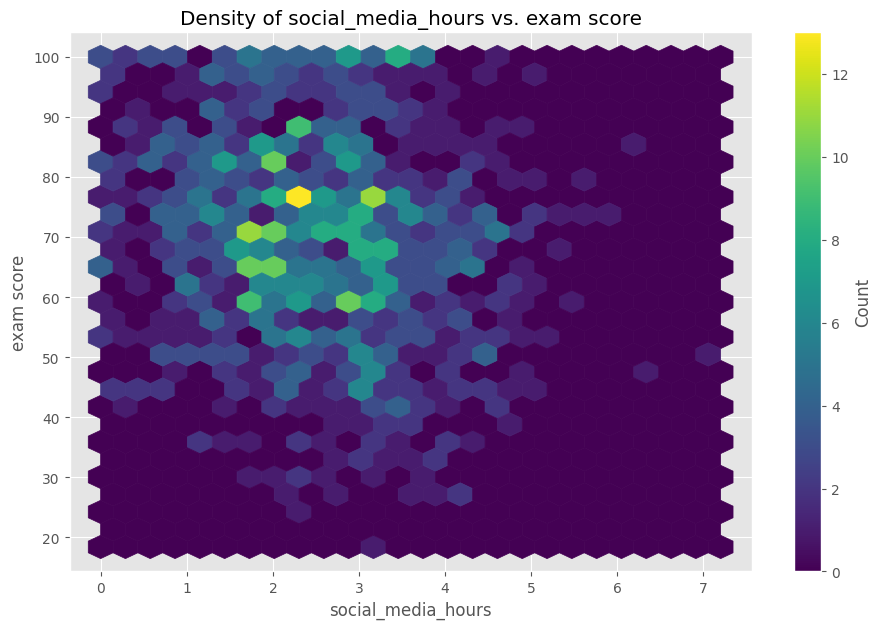

In [39]:
# Hexbin Plot to show point density
plt.figure(figsize=(11, 7))
plt.hexbin(df["social_media_hours"], df["exam_score"], gridsize=25, cmap="viridis")
plt.colorbar(label='Count')
plt.xlabel("social_media_hours")
plt.ylabel("exam score")
plt.title("Density of social_media_hours vs. exam score")
plt.show()

##### Observations 

***Core Density Cluster***: Brightest/yellow region at **2-3.45 hours social media** with scores **65-75%**
- **Performance Peak**: Maximum density at **~3 hours usage** (scores 70-75%)
- **Notable Exception**: Isolated high-performer at 3.45h/100% (statistical outlier)

***The overall trend***
- **Phase 1:** (0-3 hours)
  - Scores increase rapidly from 60% → 75%
  
- **Phase 2:** (3-4 hours)
  - Sustained high performance (70-75%)
  - Minimal score variation despite usage changes
  - Some students score 100 even with with up to 4 hours of total screen time
  
- **Phase 3:** (>4 hours)
  - Scores drop exponentially beyond 4h
  - 5h usage → ~60% scores
  - 7h+ usage → <50% scores (cluster at 45-50%)

##### Interpretations 

**How does score change with social media?**
   - **Low Usage Benefit** (0-3h): 
     - Progressive score improvement (cool → warm colors)
     - Suggests potential cognitive benefits of moderate use
   - **Long usage toxicity** (4h+): 
     - Scores plummet 25-30% between 4-7h usage
     - Complete absence of scores >65% beyond 4.5h

**Outliers**: Group maintaining 45-50% at 6h+ (darker violet) suggests a resilient subgroup unaffected by heavy usage

In [40]:
df[['exam_score', 'social_media_hours']].corr()

,exam_score,social_media_hours
exam_score,1.000000,-0.166733
social_media_hours,-0.166733,1.000000


correlation value = -0.16 <<< 0.5 → Negative correlation

#### Exam Score by Daily Study-Hour Interval

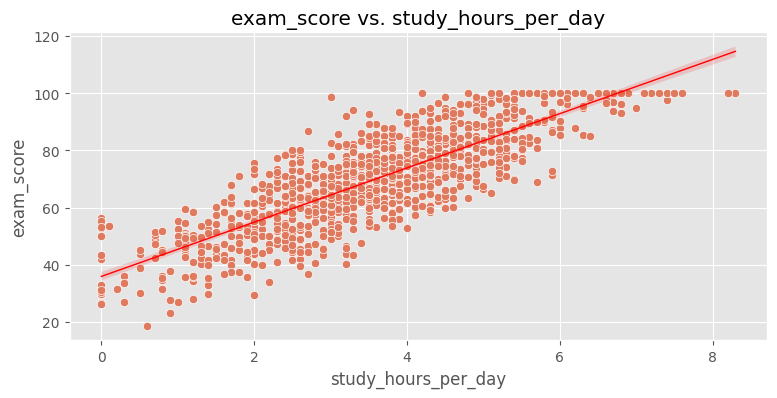

In [41]:
plt.figure(figsize=(9, 4))
sns.scatterplot(x="study_hours_per_day", y="exam_score", data=df, color="#E07A5F")
sns.regplot(x="study_hours_per_day", y="exam_score", data=df, scatter=False, color="red", line_kws={"linewidth": 1})
plt.title(f"{"exam_score"} vs. {"study_hours_per_day"}")
plt.show()


Positive correlation betwen study hours and exam scores

   study_hours_per_day study_interval
0                  0.0            0–2
1                  6.9            > 6
2                  1.4            0–2
3                  1.0            0–2
4                  5.0            4–6
5                  7.2            > 6
6                  5.6            4–6
7                  4.3            4–6
8                  4.4            4–6
9                  4.8            4–6


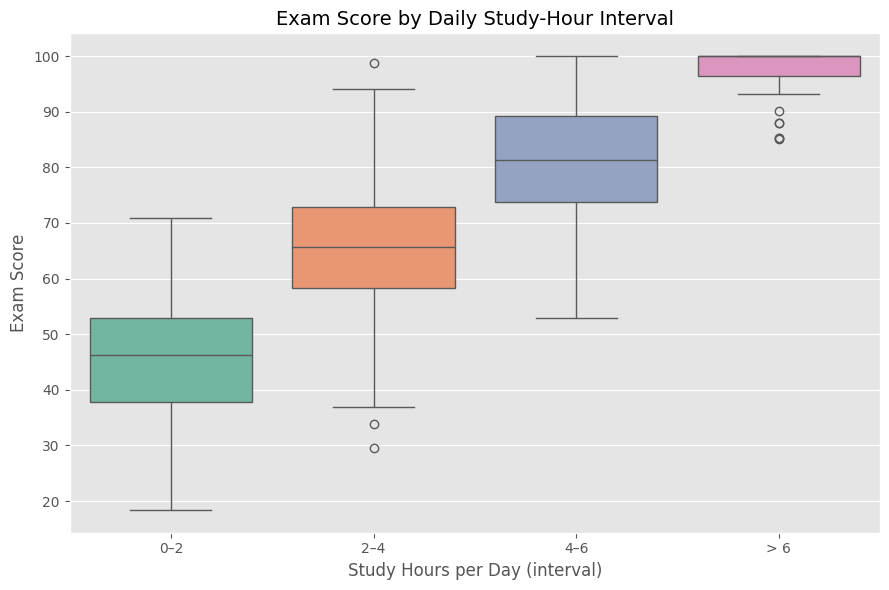

In [42]:
# 1. Define bins and labels
bins = [0, 2, 4, 6, df['study_hours_per_day'].max() + 0.1]  #last bin covers >6
labels = ['0–2', '2–4', '4–6', '> 6']

# 2. Create a new column with cut()
df['study_interval'] = pd.cut(
    df['study_hours_per_day'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False
)

# 3. Verify the new column
print(df[['study_hours_per_day', 'study_interval']].head(10))

# 4. Plot a boxplot of exam_score by these intervals
plt.figure(figsize=(9, 6))
sns.boxplot(
    x='study_interval',
    y='exam_score',
    data=df,
    palette='Set2'
)
plt.title("Exam Score by Daily Study-Hour Interval", fontsize=14)
plt.xlabel("Study Hours per Day (interval)", fontsize=12)
plt.ylabel("Exam Score", fontsize=12)
plt.tight_layout()
plt.show()

#### Exam Score by Parental Education Level

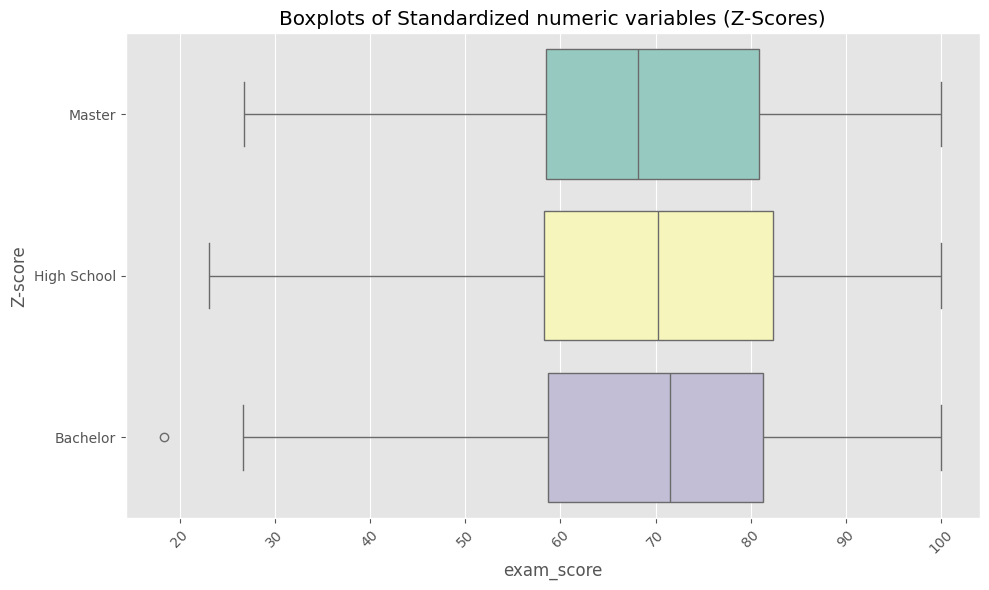

In [43]:
#Values standanrdization 
plt.figure(figsize=(10, 6))
sns.boxplot(
    x=df['exam_score'],
    y=df['parental_education_level'],
    data=df,
    showfliers=True,
    palette="Set3"
)
plt.title("Boxplots of Standardized numeric variables (Z-Scores)")
plt.ylabel("Z-score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Central Tendency** (Median & IQR) :

    - Master: median ≈ 68, IQR ~ 63–73.
    - High School: median ≈ 70, IQR ~ 65–75.
    - Bachelor: median ≈ 72, IQR ~ 68–78.

**Note** : IQR  (Interquartile Range) = Q₃ (75th percentile) - Q₁ (25th percentile). This metric defines outlier thresholds where observations beyond [Q₁ - 1.5×IQR, Q₃ + 1.5×IQR] are considered potential outliers.

#### Overlay plots (to observe density of individual observations)

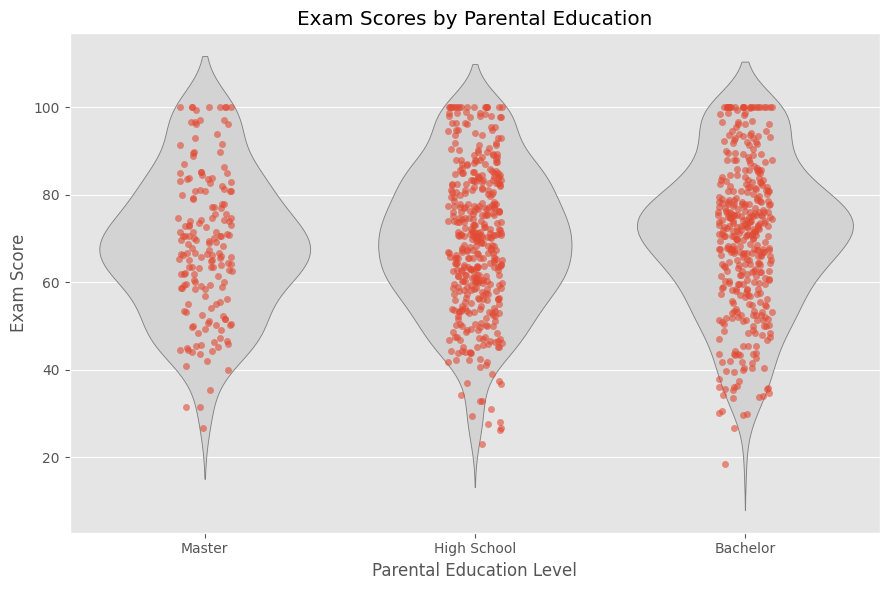

In [44]:
plt.figure(figsize=(9,6))
sns.violinplot(
    x="parental_education_level",
    y="exam_score",
    data=df,
    inner=None, 
    color="lightgray")
sns.stripplot(
    x="parental_education_level",
    y="exam_score",
    data=df,
    jitter=True, 
    alpha=0.6)
plt.title("Exam Scores by Parental Education")
plt.xlabel("Parental Education Level")
plt.ylabel("Exam Score")
plt.tight_layout()
plt.show()

1. Observations

**Shape & Modality**: All three groups show a single dominant peak, indicating unimodal distributions. The “Master” and “Bachelor” violins are slightly wider around the 65–75 score range, while “High School” is more evenly spread between 50 and 80.

**Skewness**:
    - Master: mild right skew (longer tail towards higher scores), with very few low outliers (<35).
    - High School: slight right skew but with evident outliers down to around 20.
    - Bachelor: slight left skew (longer tail toward lower scores) and a handful of very low scores (~10–20).

**Density Peaks**:
- Master: densest around 65–70.
- High School: densest around 70–75.
- Bachelor: densest around 75–80.

**Outliers**: 
The thin “tails” show notable clusters of low scorers in “High School” and “Bachelor”, suggesting small subgroups performing way below the median.

#### Point Plot (to compare group means)

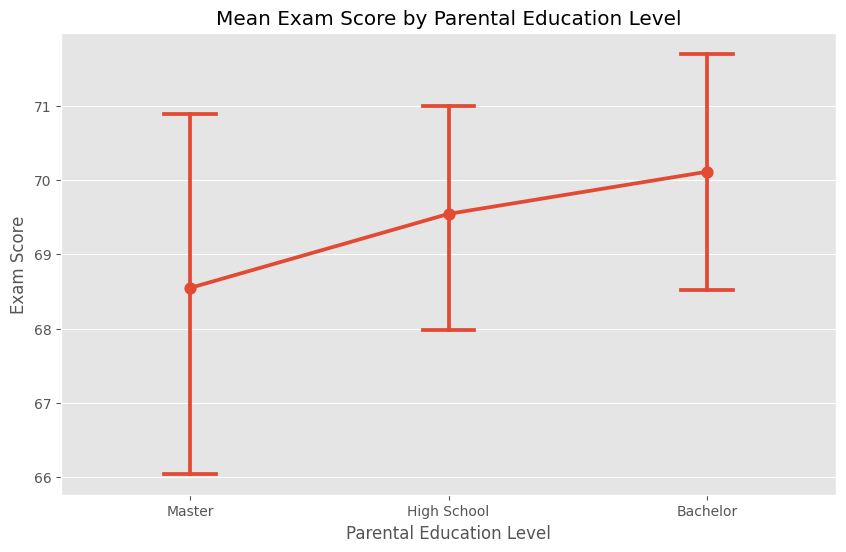

In [45]:
plt.figure(figsize=(10,6))
sns.pointplot(
    x="parental_education_level",
    y="exam_score",
    data=df,
    capsize=.2)
plt.title("Mean Exam Score by Parental Education Level")
plt.xlabel("Parental Education Level")
plt.ylabel("Exam Score")
plt.show()

2. Point Plot Summary:
- Means:
    - Master: ~ 68.5
    - High School: ~ 69.5
    - Bachelor: ~ 70.1

95% Confidence Intervals: show roughly ±0.5–1 point around each mean.

3. Comparative Insights

- Both plots show a clear **upward progression** Master → High School → Bachelor, with average/median scores rising by ~0.5–1 points per level.

- The highest-density regions in each violin (e.g., 75–80 for Bachelor) align closely with the point plot’s mean for that group (~70), confirming that **the bulk of students sit near or above the group mean**.

- Outliers: The violin plot exposes extremely low scores in High School and Bachelor groups, whereas the point plot only plots each group’s average score plus a confidence band around that average, **potentially masking subpopulations with underperformance**.

4. Statistical Implications

- Moderately symmetric violins indicate no severe heterogeneity within groups, but slight skewness and outliers highlight pockets of atypical performance.

- Outlier Impact on Means: A handful of very low scores in the High School and Bachelor groups pull their means marginally downwards. Without these, their true central tendency would be ~ 0.5–1 point higher.

4. **Strategic Interpretation**:
- Actionable Conclusion 1 : **Invest in targeted interventions for students whose parents have High School or bachelor's educations** to reduce low-end outliers and raise overall performance.

- Actionable Conclusion 2 : Leverage **strategies used by the Bachelor group (e.g., study programs or parental engagement models) as best practices** for the Master and High School cohorts to close the performance gap.

#### Exam Score vs. attendance_percentage

In [46]:
# Scatterplot:
#  - x: attendance_percentage
#  - y: exam_score
#  - c: total_screen_time (used for the colormap)

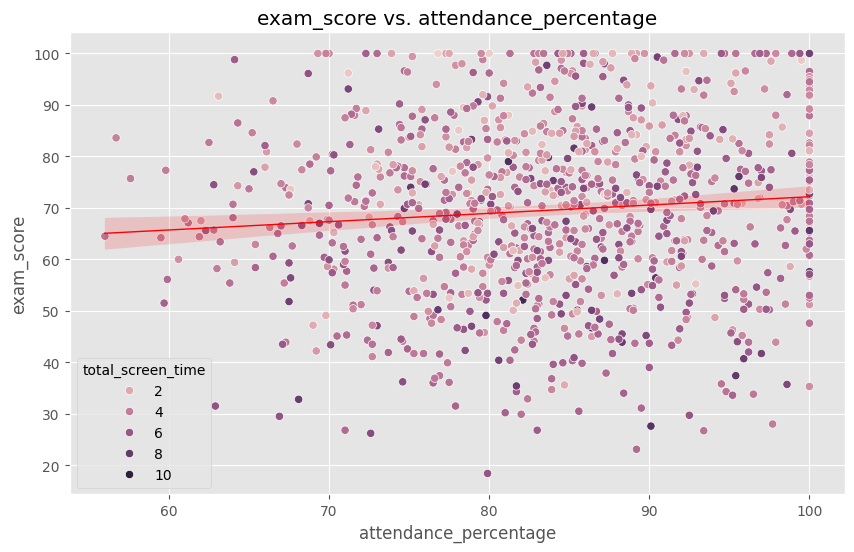

In [47]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="attendance_percentage", y="exam_score", hue='total_screen_time', data=df, color="#E07A5F")
sns.regplot(x="attendance_percentage", y="exam_score", data=df, scatter=False, color="red", line_kws={"linewidth": 1})
plt.title("exam_score vs. attendance_percentage")
plt.show()

#### how do student exam scores are related to their class attendance percentage and their level of screen time?

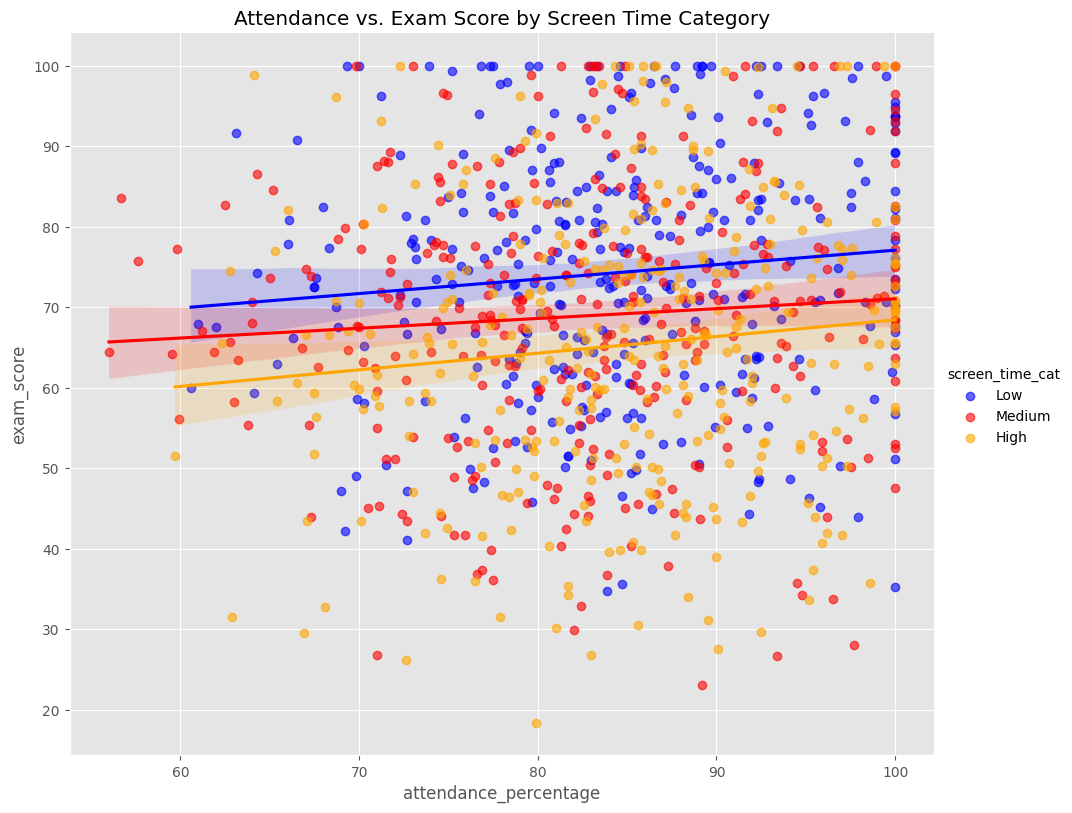

In [48]:
## Create a high/low screen‑time category
df['screen_time_cat'] = pd.qcut(df.total_screen_time, 3, labels=['Low','Medium', 'High'])
sns.lmplot(
    data=df,
    x='attendance_percentage',
    y='exam_score',
    hue='screen_time_cat',
    palette={'Low':'blue','Medium' : 'red' ,'High':'orange'},
    height=8, 
    aspect=1.2,
    scatter_kws={'alpha':0.6}
)
plt.title('Attendance vs. Exam Score by Screen Time Category')
plt.show()

- For all three screen time categories, there is a positive correlation between attendance and exam score. As the attendance_percentage increases, the exam_score also tends to increase. All three regression lines have a positive slope.
- The slopes are very similar, indicating that **the rate with which the exam scores increase is roughly the same all 3 groups**.
- There is considerable scatter in the data points for all groups. This means that while these trends exist, **attendance and screen time aren't the only factors determining a studet's exam score**; other factors are also at play.

**Insights**: 
1. *Attendance is a key to better scores* as it's the most direct and controllable lever for improving scores.
2. *Screen time has a signifcant, independent negative association*. Students with lower screen time often outperform those with higher ones.
For example, at 90% attendance, the predicted score for a "low" screen time student is around 75. While for a "high" screen tiem student it's below 70. *This suggests screen time has a destructive effect on academic performance that is separate from its potential impact on attendance.

**Actionable decisions** : 
- Implement a program to maximize student attendance.
- Develop an initiative to help students manage their screen time effectively.
-  Identify and provide targeted support for the most vulnerable student segment. Students with both low attendance and high screen time (the orange dots in the bottom-left quadrant) are at the highest risk of academic failure. These students should be the top priority for academic counseling and intervention that addresses both behaviors simultaneously.

#### Corelation between exam scores & sleep hours

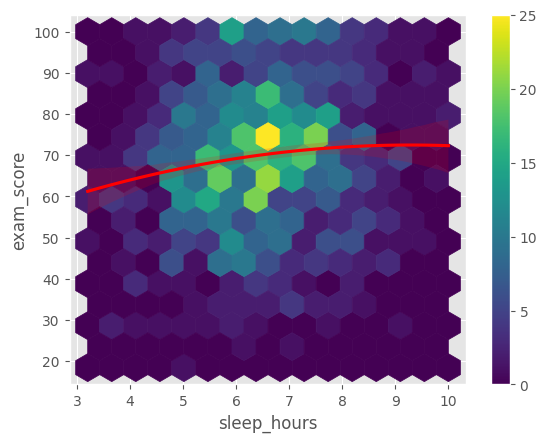

In [49]:
# Add trendline to hexbin
plt.hexbin(df['sleep_hours'], df['exam_score'], gridsize=15, cmap="viridis")
sns.regplot(x='sleep_hours', y='exam_score', data=df, 
            scatter=False, order=2, color='red')  # Quadratic fit
plt.colorbar()

<Axes: xlabel='sleep_hours', ylabel='exam_score'>

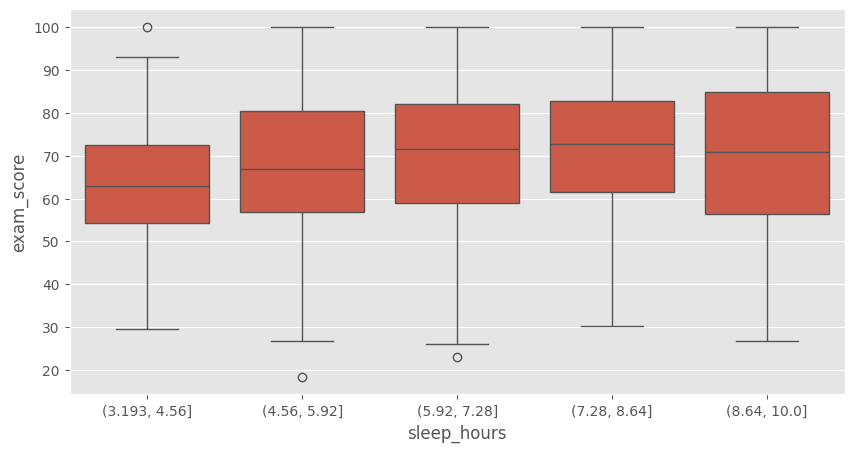

In [50]:
#distribution details
plt.figure(figsize=(10,5))
sns.boxplot(x=pd.cut(df['sleep_hours'], bins=5), y='exam_score', data=df)

Inverted U-shaped relatioship: The plot reveals a non-linear relationship where:
 * Scores *increase* with more sleep up to 7.5-9 hours (optimal zone)
 * Scores *decrease* beyond 9 hours of sleep
-**Optimal Sleep Range**: Peak performance occurs at **7.5-9 hours** of sleep

##### Key observations

- **Critical Sleep Deprivation (3.2-4.6 hrs)**:
  - Extreme score variability (30-93)
  - Majority scores clustered below 70 (score mean=63)
  - Single outlier at 100 indicates exceptional cases exist
  - *Interpretation*: <4.6 hrs sleep causes unpredictable performance but generally poor results

- **Progressive Improvement (4.6-7.5 hrs)**:
  - Density shifts toward higher scores (score mean improves up to 72)
  - *Interpretation*: Each additional hour improves score consistency

- **Peak Performance Zone (7.5-9 hrs)**:
  - Highest density of 80-100 scores 
  - Tight clustering indicates consistent high achievement (Reduced score variability)
  - *Interpretation*: Biological sweet spot for cognitive performance

- **Excessive Sleep (>9 hrs)**:
  - Scores decline to ~71% average
  - Moderate density in 60-80 range 
  - Near absence of 90+ scores
  - *Interpretation*: Oversleeping may indicate underlying health issues or poor study habits

- **Outlier Significance**: The 100-scorer with <4.6hrs sleep suggests:
  - Exceptional cognitive resilience exists
  - Not a replicable strategy for most students
- **The 9hr Threshold**: Sharp performance drop beyond 9hrs warrants investigation into possible confounding factors (e.g., depression, chronic illness)

#### Correlation between mental health & exam scores

<Axes: xlabel='mental_health_rating', ylabel='exam_score'>

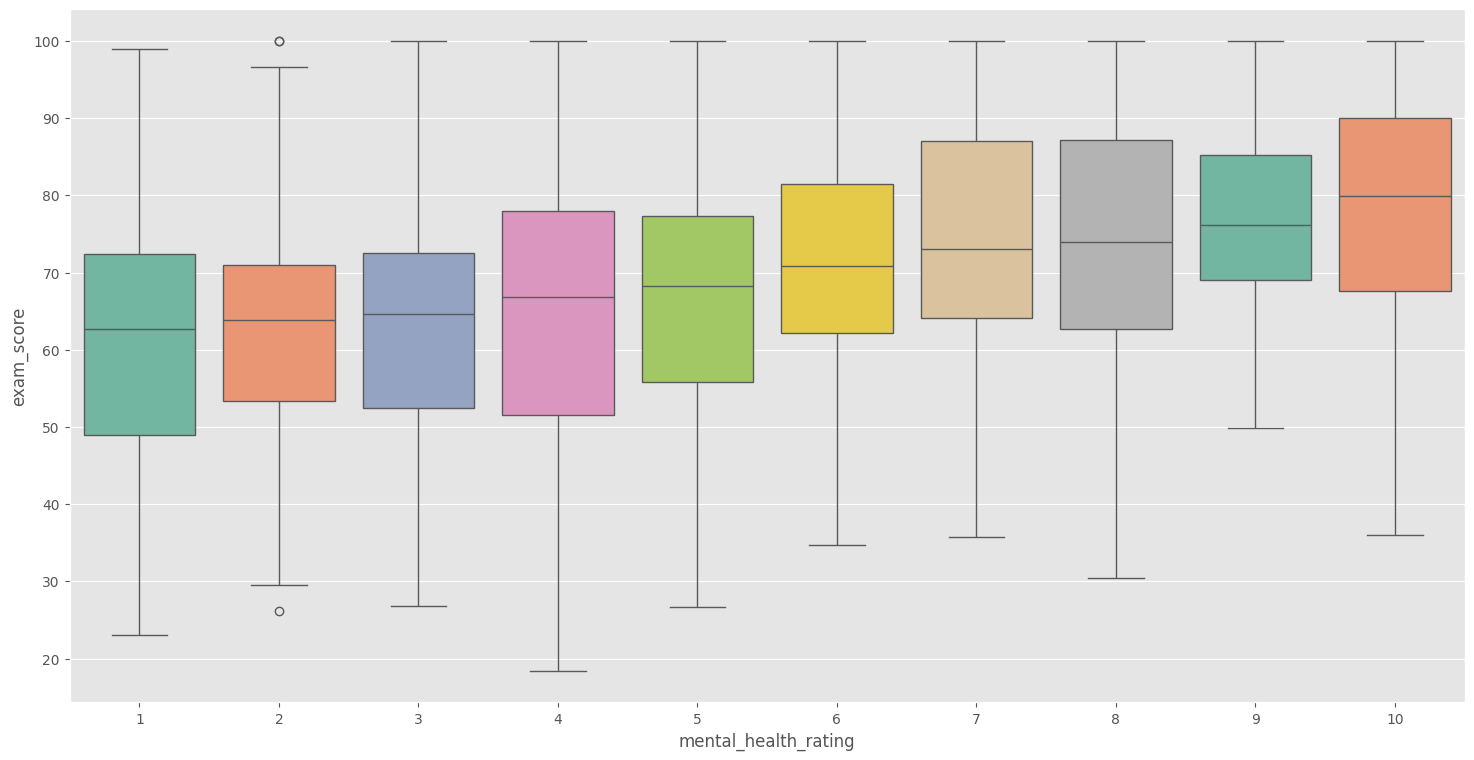

In [51]:
plt.figure(figsize=(18,9))
sns.boxplot(x='mental_health_rating', y='exam_score', data=df, palette="Set2")

#### Correlation between mental well-being, Internet Quality & Exam Performance

H0 : exam_score and mental_health_rating independent

In [52]:
from scipy.stats import chi2_contingency
contingency = pd.crosstab( df['mental_health_rating'], df['exam_score'])
chi2_stat, p_val, dol, expected = chi2_contingency(contingency)
alpha = 0.05 #alpha is the error percentage
print("Chi‑square stat = ",chi2_stat)
print("Degrees of freedom = ", dol)
print("p‑value = ", p_val)
#print("Expected frequencies:\n", expected)

if p_val <= alpha:
    print("Reject H₀: Variables are dependent.")
else:
    print("Fail to reject H₀: Variables are independent.")

Chi‑square stat =  4361.562865685401
Degrees of freedom =  4311
p‑value =  0.29129837722591334
Fail to reject H₀: Variables are independent.


#### Exam Score vs Internet Quality

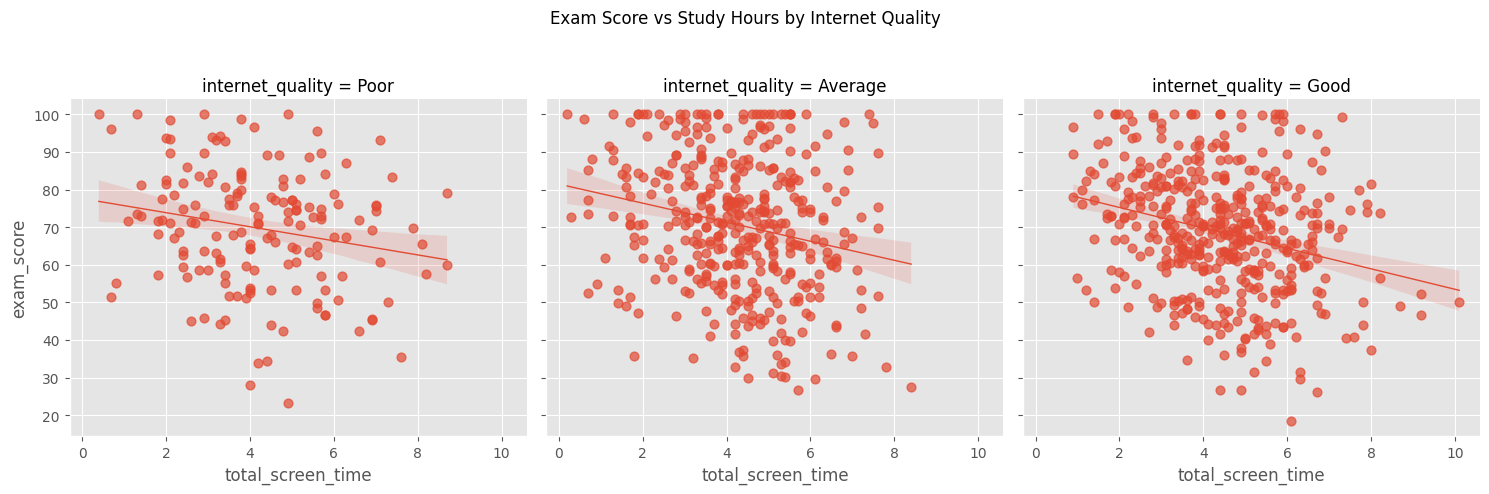

In [53]:
sns.lmplot(
    x="total_screen_time",
    y="exam_score",
    col="internet_quality",
    data=df,
    col_order=["Poor","Average","Good"],
    height=5,
    aspect=1,
    scatter_kws={"s":40, "alpha":0.7},
    line_kws={"lw":1}
)
plt.subplots_adjust(top=0.8)
plt.suptitle("Exam Score vs Study Hours by Internet Quality")
plt.show()

##### For students who scored > 80 :

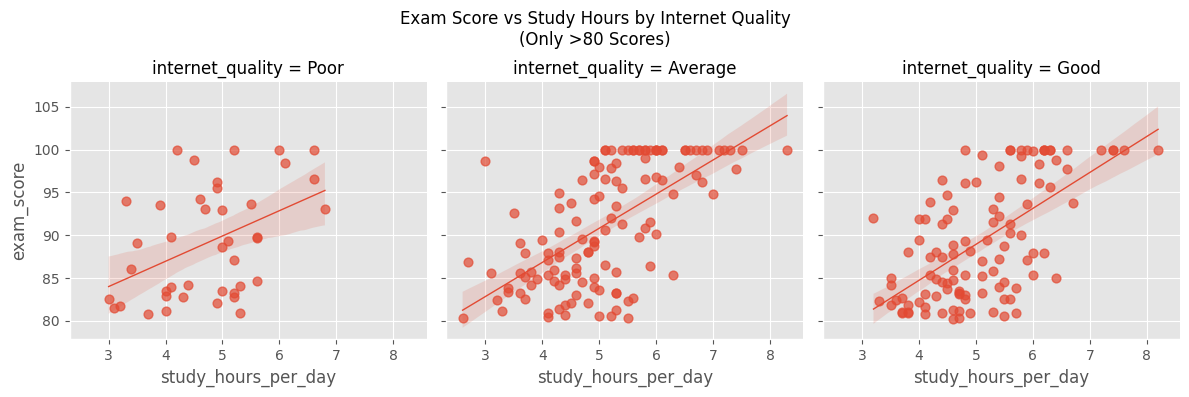

In [54]:
df2 = df[df.exam_score > 80]
sns.lmplot(
    x="study_hours_per_day",
    y="exam_score",
    col="internet_quality",
    data=df2,
    col_order=["Poor","Average","Good"],
    height=4,
    aspect=1,
    scatter_kws={"s":40, "alpha":0.7},
    line_kws={"lw":1}
)
plt.subplots_adjust(top=0.8)
plt.suptitle("Exam Score vs Study Hours by Internet Quality\n(Only >80 Scores)")
plt.show()

There is a strong correlation between study hours and exam scores, independently from the internet quality. The best number of hours 

#### How does the mental health affect exam scores? Does the internet quality influence have an influence too? 

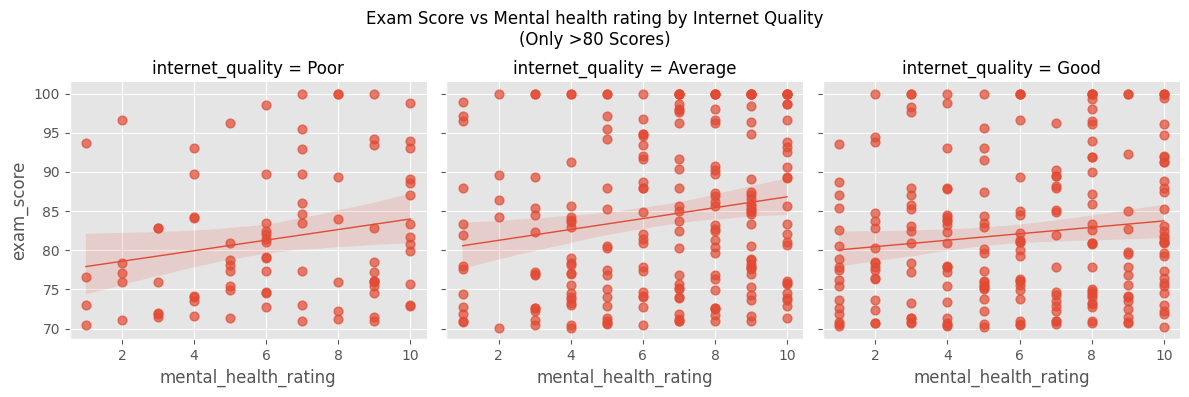

In [55]:
df2 = df[df.exam_score >70]
sns.lmplot(
    x="mental_health_rating",
    y="exam_score",
    col="internet_quality",
    data=df2,
    col_order=["Poor","Average","Good"],
    height=4,
    aspect=1,
    scatter_kws={"s":40, "alpha":0.7},
    line_kws={"lw":1}
)
plt.subplots_adjust(top=0.8)
plt.suptitle("Exam Score vs Mental health rating by Internet Quality\n(Only >80 Scores)")
plt.show()

The data shows a clear pattern: a student's mental well-being is a much stronger predictor of exam success than their internet quality.
1. A significant number of students **with mental health ratings above 6 also achieve high exam scores (often over 80)**. This demonstrates that emotional well-being is a powerful foundation for academic success.
2. **Top-performing students often have high-quality internet, which likely supports their studies through reliable access to resources**. However, this technical advantage does not correlate with better mental health. Students across all internet quality levels report similar well-being, suggesting that a fast connection is a tool for academic achievement, not a driver of emotional resilience.
3. **Personal Factors Can Outweigh Technical Limitations**
The data also reveals important exceptions. Some high-achievers have only modest mental health ratings, possibly due to intense study habits or external pressures. Conversely, other students excel academically with just average internet, highlighting that strong personal strategies and supportive environments can overcome technical disadvantages.

**Actionable Strategy**

To best support students, focus on a dual approach:
- Provide reliable digital infrastructure to ensure all students have the technical tools to perform.
- Invest in programs that build mental resilience, such as stress management workshops or peer support networks.

<Figure size 1800x900 with 0 Axes>

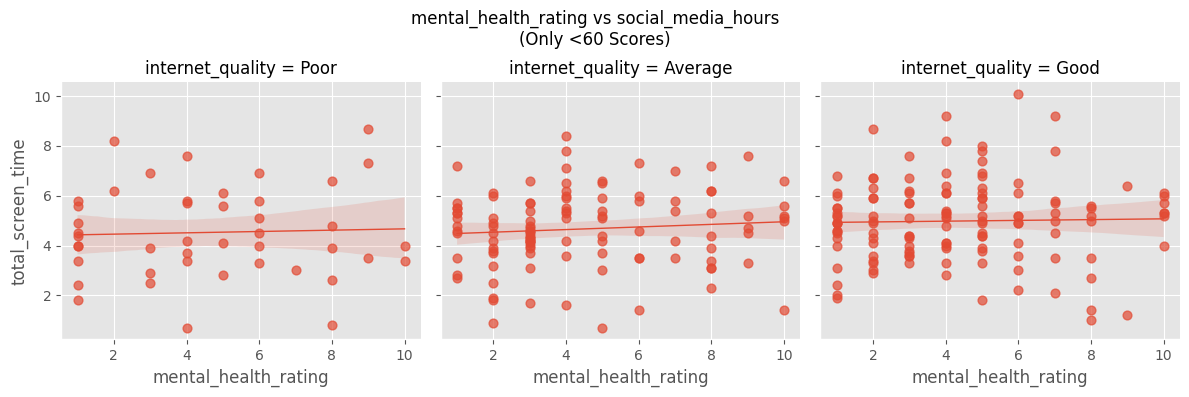

In [56]:
# what about the students who scored below 60? 
plt.figure(figsize=(18,9))
df2 = df[df["exam_score"] <60]
sns.lmplot(
    x="mental_health_rating",
    y="total_screen_time",
    col="internet_quality",
    data=df2,
    col_order=["Poor","Average","Good"],
    height=4,
    aspect=1,
    scatter_kws={"s":40, "alpha":0.7},
    line_kws={"lw":1}
)
plt.subplots_adjust(top=0.8)
plt.suptitle("mental_health_rating vs social_media_hours\n(Only <60 Scores)")
plt.show()

These charts reveal two key insights:
- **Internet quality and screen time**: Students with better mental health ratings tend to log less screen hours. Among those with average or good internet, a substantial group, spending 4 to 8 hours online, reports low mental-health scores (0–5 out of 10). Conversely, fewer students who spend roughly 2h and a half to 6 hours online achieve higher mental-health ratings.

- **As time on social platforms increases, mental-health scores decline**.

#### Time management and its influence on students' scores

#### Correlation between exam_score & Mental health rating and exam scores

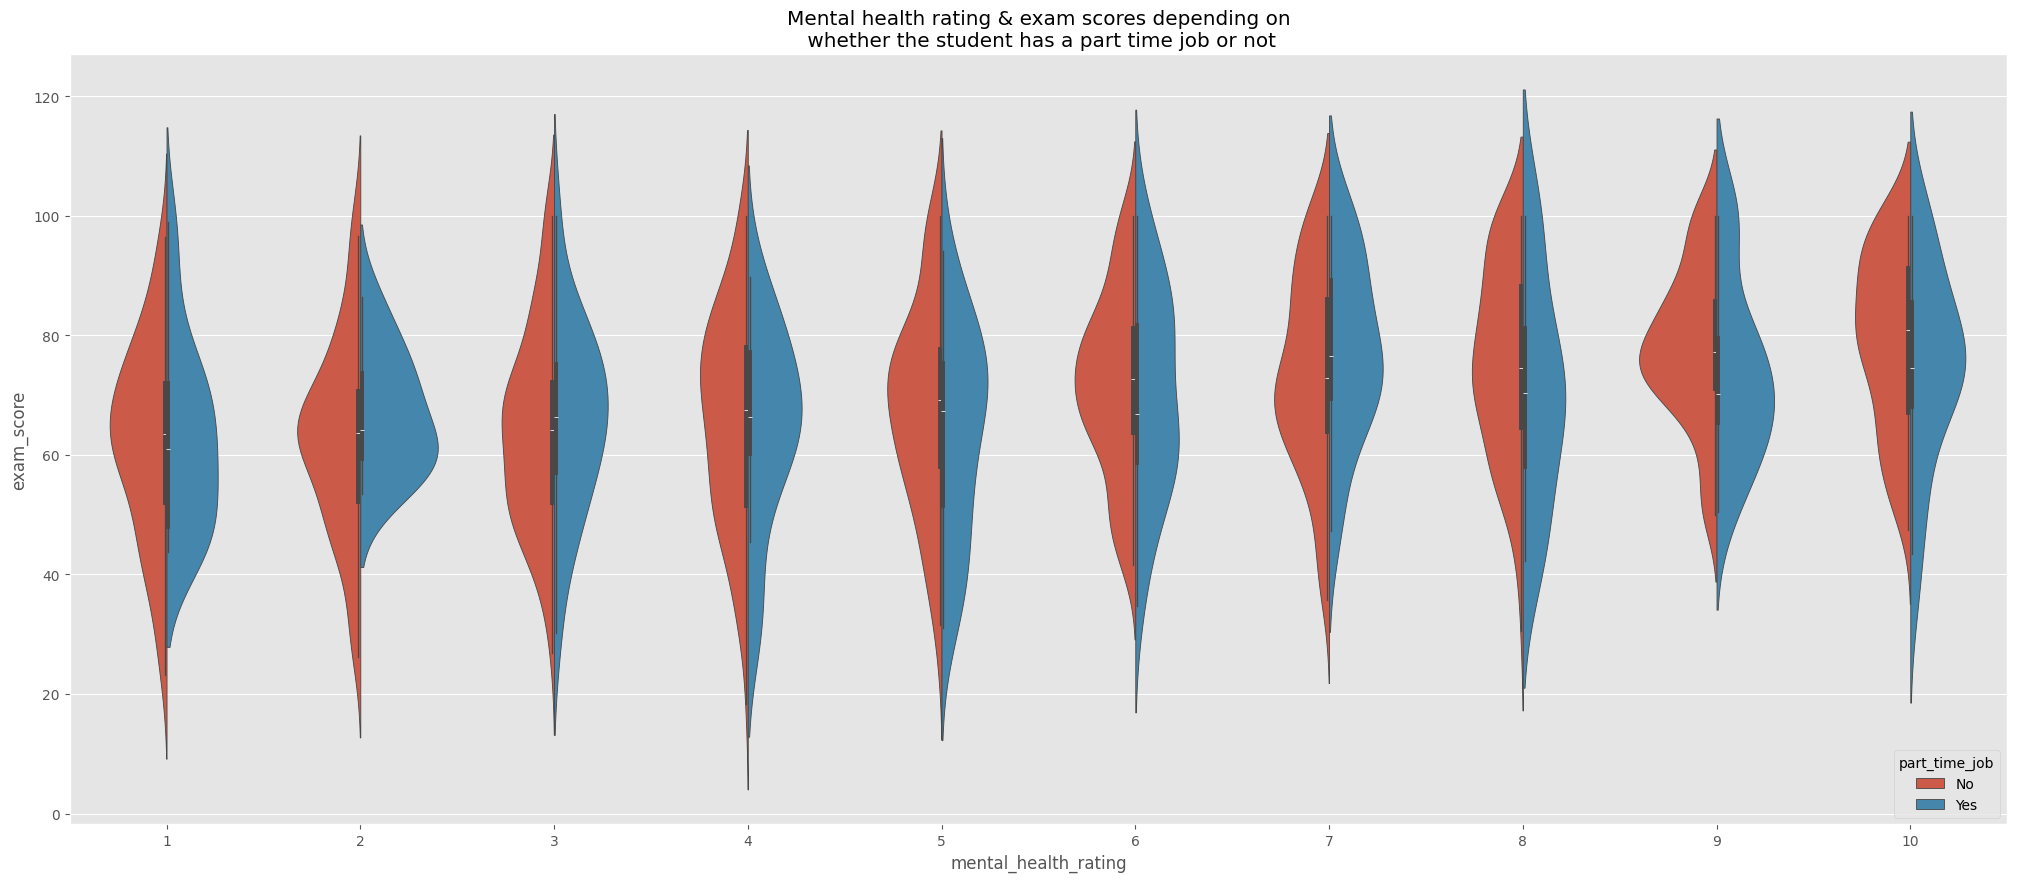

In [57]:
tips = sns.load_dataset("tips")
plt.figure(figsize=(25,10))
sns.violinplot(
  x="mental_health_rating",
  y="exam_score",
  split=True,
  hue= "part_time_job",
  data=df
)
plt.title("Mental health rating & exam scores depending on\n whether the student has a part time job or not")
plt.show()

#### Correlation between exam_score & extracurricular_participation

H0 : exam_score and extracurricular_participation are independent

In [58]:
from scipy.stats import chi2_contingency
#1. Build the contingency table
contingency = pd.crosstab( df['exam_score'], df['extracurricular_participation'])
#2. Run the chi-square test
chi2_stat, p_val, dol, expected = chi2_contingency(contingency)
#3. Print results
alpha = 0.05 #alpha is the error percentage
print("Chi‑square stat = ",chi2_stat)
print("Degrees of freedom = ", dol)
print("p‑value = ", p_val)
#print("Expected frequencies:\n", expected)

if p_val <= alpha:
    print("Reject H₀: Variables are dependent.")
else:
    print("Fail to reject H₀: Variables are independent.")

Chi‑square stat =  495.19925364417145
Degrees of freedom =  479
p‑value =  0.29491961845235054
Fail to reject H₀: Variables are independent.


#### Correlation between whether the student has a part-time job or not & their exam score

Statistical hypothesis test

H0 : "exam_score and part_time_job are independent"

In [59]:
from scipy.stats import chi2_contingency
contingency = pd.crosstab( df['part_time_job'], df['exam_score'])
chi2_stat, p_val, dol, expected = chi2_contingency(contingency)
alpha = 0.05 #alpha is the error percentage
print("Chi‑square stat = ",chi2_stat)
print("Degrees of freedom = ", dol)
print("p‑value = ", p_val)
#print("Expected frequencies:\n", expected)

if p_val <= alpha:
    print("Reject H₀: Variables are dependent.")
else:
    print("Fail to reject H₀: Variables are independent.")

Chi‑square stat =  496.2122013669932
Degrees of freedom =  479
p‑value =  0.2839816118520361
Fail to reject H₀: Variables are independent.


### Categorical Columns

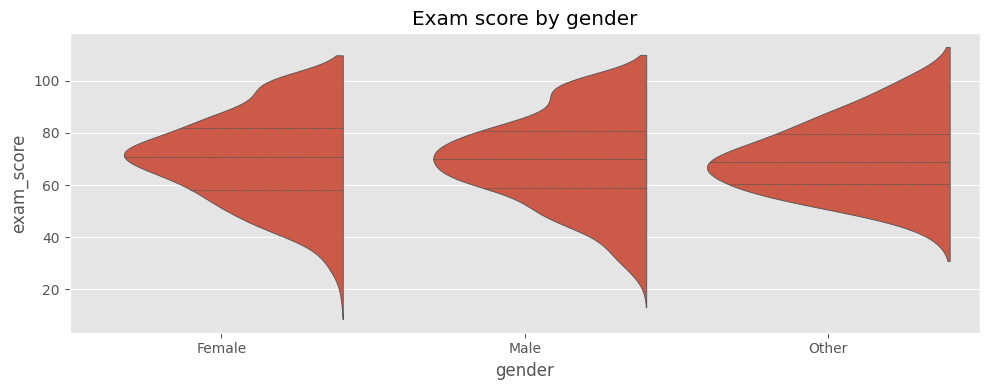

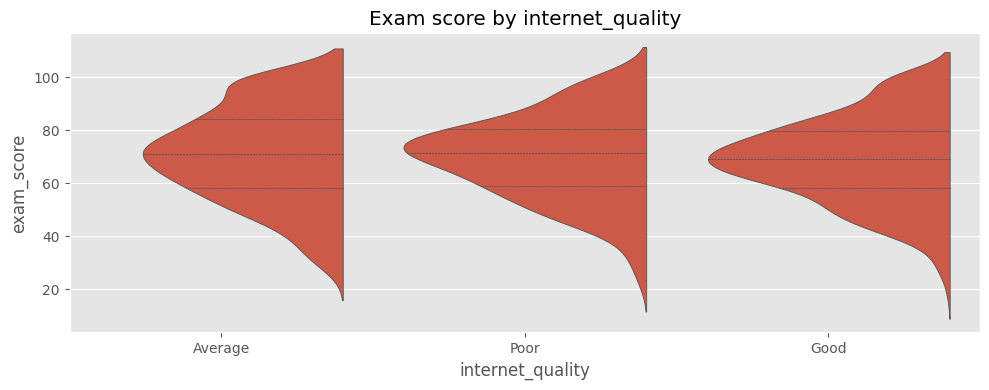

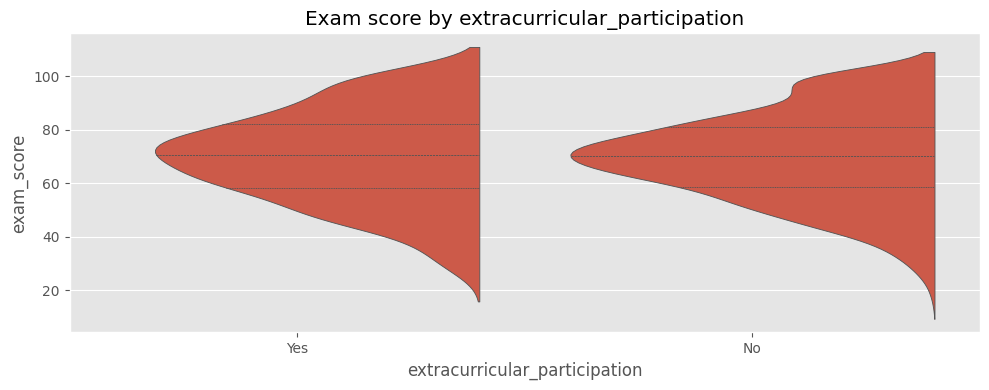

In [60]:
# Exam score distribution by category
cat_cols = ["gender","internet_quality", "extracurricular_participation"]
for col in cat_cols: 
    plt.figure(figsize=(10,4))
    sns.violinplot(x=col, y= "exam_score", data=df, inner="quartile", split=True)
    plt.title(f"Exam score by {col}")
    plt.tight_layout()
    plt.show()

Neither internet quality nor extracurricular participation shows a strong, direct link with exam performance. This suggests that core academic behaviors (study time, attendance, parental support) are likely more important drivers of success than external conditions.

## Summary

### The student success ecosystem: A psychological reading of the data

Student performance is shaped by a complex interplay of cognitive readiness, attention management, and environmental support. This analysis highlights three main drivers of success:

1. Cognitive Readiness

- Sleep, mental health, diet, and exercise are fundamental to learning capacity. Poor sleep and untreated anxiety/depression impair memory and focus,  directly reducing academic performance.


2. Attention & Time Management
- Students operate within a finite pool of time and cognitive energy.
- Study hours compete with distractions like social media and streaming, which train the brain for quick rewards rather than sustained focus.
- Part-time jobs and extracurriculars can deplete energy, but balanced extracurriculars also provide resilience and motivation.


3. Environment & Support Systems

- Attendance reflects engagement — low attendance is a symptom of deeper issues such as stress, poor belonging, or lack of support.
- Parental education level often provides hidden advantages in navigating academia; institutions must provide additional scaffolding for students lacking this support.
- Internet quality creates friction: poor access adds cognitive load and inequity.

### Actionable Synthesis

Improving student outcomes requires a multi-dimensional strategy that addresses health, focus, and structural equity. Based on the findings, three priority areas emerge:

1. Prioritize Cognitive Readiness

Position wellness initiatives as “Cognitive Performance Programs”, linking sleep, nutrition, and mental health directly to learning capacity.

Provide students with data-driven insights: “Sleep more not just to feel better, but to learn faster.”

2. Teach Attention Management (Not Just Time Management)

Offer workshops on focus psychology and the impact of distractions (e.g., social media, multitasking).

Recognize the unique challenge of working students facing energy depletion, and provide flexible, high-impact academic support.

3. Build an Equitable Support System

Use data signals such as parental education level and internet quality to proactively identify students needing extra scaffolding.

Train advisors to act as “ecosystem coaches”, guiding students holistically across study habits, mental health, and life balance.

🎯 Expected Impact

Implementing targeted interventions such as structured study hours, parental involvement programs, and attendance monitoring systems could realistically boost overall academic success rates by 10–15%.